In [1]:
from os.path import join
import os
import pandas as pd
pd.set_option("display.max_colwidth", None)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import numpy as np
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer.factor_analyzer import FactorAnalyzer
import warnings
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

In [2]:
DIR = "/data/NewsGuard/"
FIGURES = "/home/jluehring/newsguard/newsguard-review-paper/figures/"
TABLES = "/home/jluehring/newsguard/newsguard-review-paper/tables/"

In [3]:
# merged snapshots twice per (at the beginning and end of each month)
# see merge strategy in merge_snapshots.ipynb
df_total = pd.read_csv(join(DIR, "newsguard_twice_month.csv"),
                       parse_dates=["file_date"],
                       low_memory=False)

# sampled only from the middle of the month
df_15 = pd.read_csv(join(DIR, "newsguard_mid_month.csv"),
                    parse_dates=["file_date"],
                    low_memory=False)

# sampled only from the beginning of the month
df_02 = pd.read_csv(join(DIR, "newsguard_first_month.csv"),
                    parse_dates=["file_date"],
                    low_memory=False)


# first ever version of newsguard database
df_first = pd.read_csv(join(DIR, "newsguard_first_version.csv"),
                    low_memory=False)

# most recent version of newsguard database
df_recent = pd.read_csv(join(DIR, "newsguard_recent_version.csv"),
                    low_memory=False)

In [4]:
#standardize plots
def custom_plots(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.grid(False)
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    sns.despine(ax=ax)
    plt.gca().yaxis.set_ticks_position('left')
    plt.gca().xaxis.set_ticks_position('bottom')

## How volatile are trustworthiness ratings?

### How many sources have been covered (over time)?

In [5]:
print(f'In the most recent df, there are {len(df_recent)} entries, '
      f'while there are {len(df_first)} in the first version.')
print(f'The domains belong to {df_recent["Parent Domain"].nunique()} parent domains.')
print(f'The number of entries has grown by {round((len(df_recent)/len(df_first)-1)*100,2)}%')

In the most recent df, there are 12288 entries, while there are 2375 in the first version.
The domains belong to 444 parent domains.
The number of entries has grown by 417.39%


### How many sources were added vs. removed over time?

In [6]:
domain_changes = {}
#getting list of unique months to iterate through
unique_months = df_15.sort_values("file_date")["file_date"]\
                    .unique()

for i in range(1, len(unique_months)): #iterate through months
    current_month = unique_months[i] #set as current months
    previous_month = unique_months[i - 1] #set month minus one as previous month
    
    #compare domains from current month to previous month
    added_month = set(df_15[df_15["file_date"] == current_month]["Domain"].tolist())\
        - set(df_15[df_15["file_date"] == previous_month]["Domain"].tolist())
    removed_month = set(df_15[df_15["file_date"] == previous_month]["Domain"].tolist())\
        - set(df_15[df_15["file_date"] == current_month]["Domain"].tolist())
    domain_changes[current_month] = added_month, removed_month


data = []
for date, (added, removed) in domain_changes.items():
    data.append({"Date": date, 
                 "Added": len(added), 
                 "Removed": len(removed)})

domain_changes_df = pd.DataFrame(data)

print(f'Total number of added sources: {domain_changes_df["Added"].sum()}')
print(f'Total number of removed sources: {domain_changes_df["Removed"].sum()}')

print(f'Average number of added sources per month: {domain_changes_df["Added"].mean()}')
print(f'Average number of removed sources per month: {domain_changes_df["Removed"].mean()}')

Total number of added sources: 8906
Total number of removed sources: 685
Average number of added sources per month: 137.01538461538462
Average number of removed sources per month: 10.538461538461538


In [7]:
#counting number of ratings for sampling mid-month
counts_15 = df_15.groupby(df_15.file_date)\
    .size()\
    .reset_index(name="Counts")

#counting number of ratings for sampling beginning of month
counts_02 = df_02.groupby(df_02.file_date)\
    .size()\
    .reset_index(name="Counts")

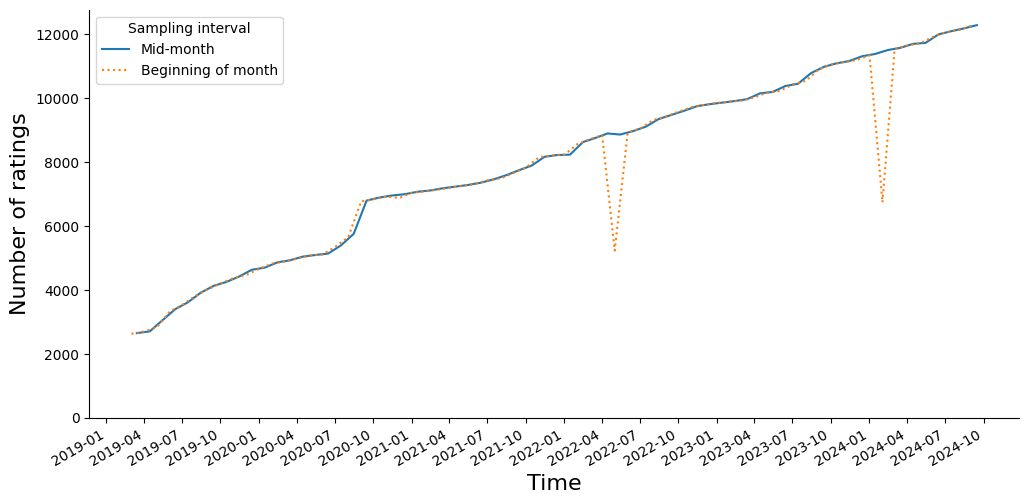

In [8]:
plt.figure(figsize=(12,6))
sns.lineplot(data=counts_15, 
             x="file_date", 
             y="Counts", 
             #color="blue", 
             label="Mid-month"
             )

sns.lineplot(data=counts_02, 
             x="file_date", 
             y="Counts", 
             #color="blue", 
             label="Beginning of month", 
             linestyle="dotted")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.gcf().autofmt_xdate()

plt.ylim(0)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Number of ratings", fontsize=16)
plt.legend(title="Sampling interval")
custom_plots()

plt.show()

In [9]:
#count the number of entries per date
counts = df_total.groupby(df_total.file_date)\
    .size()\
    .reset_index(name="Counts")

#filter may time frame may 2020 to june 2020
counts = counts[(counts["file_date"] >= "2022-04-02") & (counts["file_date"] <= "2022-07-30")]
counts

,file_date,Counts
74,2022-04-02 01:00:00,8845
75,2022-04-15 01:00:00,8898
76,2022-05-02 01:00:00,5232
77,2022-05-15 01:00:00,8864
78,2022-06-02 01:00:00,8929
79,2022-06-15 01:00:00,8971
80,2022-07-02 01:00:00,9057
81,2022-07-15 01:00:00,9109


In [10]:
print(f'In the most recent df, there are {len(df_recent[df_recent["Score"].notnull()])} '
      f'rated domains while there are {len(df_first[df_first["Score"].notnull()])} '
      'in the first version of the database.')

In the most recent df, there are 11349 rated domains while there are 2344 in the first version of the database.


For a more thorough investigation of the dips, look at ``check_fluctuations.ipynb``.

### Are there duplicates? Why?

In [11]:
# extracting duplicated domains
dup_domains = \
    df_recent[df_recent\
                .duplicated(subset="Domain", 
                            keep=False)]

# looking at only relevant columns
# dup_domains[["Domain", "Country", "Language", "Score"]]\
#     .head(10)
# looks like the some domains have different country labels

In [12]:
# counting if the score is the same for domains
# dup_domains \
#     .groupby("Domain").Score \
#     .nunique() \
#     .reset_index(name="nunique") \
#     .sort_values(by="nunique", 
#                 ascending=False)
# only three domains with different scores in different countries 

In [13]:
# dup_domains[dup_domains["Domain"] == "msn.com"]

In [14]:
# dup_domains[dup_domains["Domain"] == "example.com"]

In [15]:
df_recent["Parent Domain"]\
    .notnull()\
    .value_counts()

Parent Domain
False    6534
True     5754
Name: count, dtype: int64

In [16]:
df_recent_parents = df_recent[
                        df_recent["Parent Domain"]\
                            .notnull()]

df_recent_parents["Parent Domain"]\
    .nunique()

444

In [17]:
df_recent_parents.groupby("Parent Domain")\
    .Score\
    .nunique()\
    .value_counts()

Score
1    431
0     13
Name: count, dtype: int64

In [18]:
# inspect the duplicates
df_dups = \
    df_recent_parents[df_recent_parents\
              .duplicated(
                  subset="Parent Domain",
                  keep=False)]


# df_dups[["UUID", "Domain", 
#            "Parent Domain", "Country", 
#            "Language", "Score"]]\
#            .sort_values(by="UUID")\
#            .head(5)

# different domains share the same parent domains and UUID
# df_dups[df_dups.duplicated(keep=False)] 
# but none are completely identical

In [19]:
df_recent_UUID = \
    df_recent.drop_duplicates(
        subset=["UUID", "Domain"], 
        keep="first")

print(f'Unique domains = {df_recent["Domain"].nunique()}, \n'
      f'Unique UUIDs = {df_recent["UUID"].nunique()}, \n'
      f'Rows with unique UUID/parent domain = {len(df_recent_UUID)}.')

Unique domains = 10862, 
Unique UUIDs = 7073, 
Rows with unique UUID/parent domain = 12288.


## What is the distribution of trustworthiness?

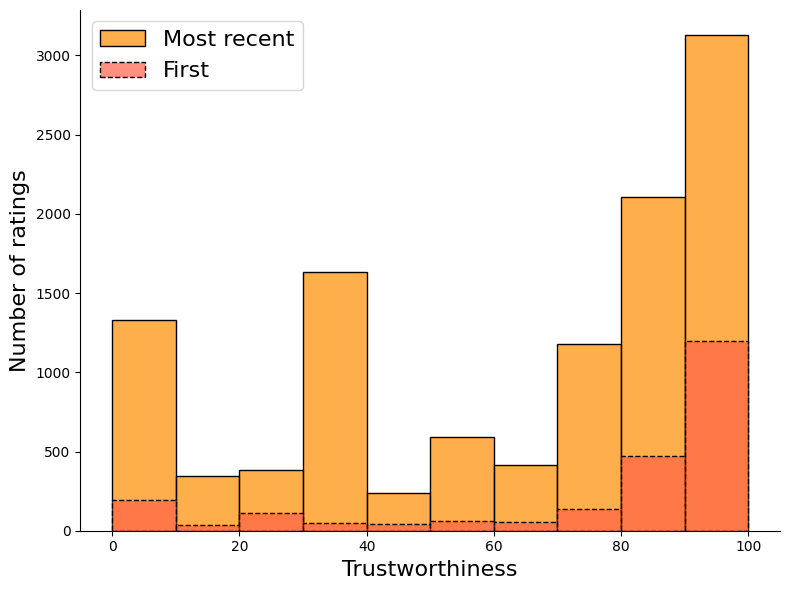

In [20]:
plt.figure(figsize=(8,6))
sns.histplot(data=df_recent, 
             x="Score", 
             bins=10, 
             alpha=0.7,
             color="darkorange",
             edgecolor="black",
             label="Most recent")

sns.histplot(data=df_first,  
             x="Score",        
             bins=10,          
             edgecolor="black",  
             alpha=0.7,
             color="tomato",
             linestyle="dashed",
             label="First")

plt.xlabel("Trustworthiness", fontsize=16)
plt.ylabel("Number of ratings", fontsize=16)
plt.legend(fontsize=16)
plt.tight_layout()
custom_plots()

plt.show()

In [21]:
df_15["file_year"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("Y")
df_15["file_month"] = pd.to_datetime(df_15.file_date)\
    .dt.to_period("M")

year_scores = df_15\
    .groupby("file_year")["Score"]\
    .agg(["mean", "std", "min", "max"])\
    .reset_index()
print(year_scores)

  file_year       mean        std  min    max
0      2019  71.767972  33.287474  0.0  100.0
1      2020  66.001125  34.087030  0.0  100.0
2      2021  63.692641  33.858325  0.0  100.0
3      2022  65.200969  33.158941  0.0  100.0
4      2023  64.532554  32.412332  0.0  100.0
5      2024  63.622522  32.620659  0.0  100.0


/tmp/ipykernel_598056/424305522.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x\


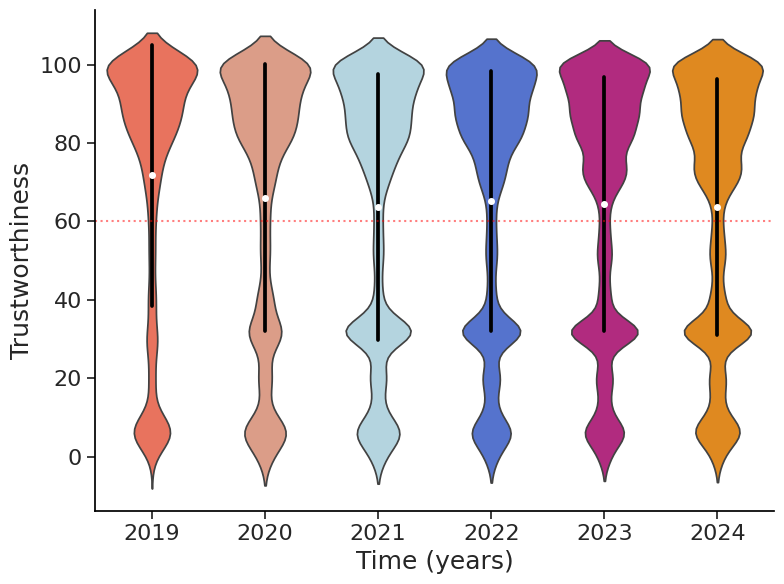

In [22]:
df_15_year = df_15.groupby("file_year")\
    .apply(lambda x: x\
           .drop_duplicates())\
            .reset_index(drop=True)

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8, 6))

year_colors = ["tomato", "darksalmon", "lightblue", "royalblue", "mediumvioletred", "darkorange"]

sns.pointplot(
    data=df_15_year, 
    y="Score", 
    x="file_year", 
    estimator="mean",
    errorbar="sd",   
    color="black",
    markersize=2,
    linestyle='none') 

sns.pointplot(
    data=year_scores, 
    y="mean", 
    x="file_year", 
    estimator="mean",
    color="white", 
    linestyle='none',  
    markers="o",
    markersize=3) 

sns.violinplot(x="file_year", 
               y="Score",
               hue="file_year",
               density_norm="count",
               data=df_15_year,
               inner=None,
               palette=year_colors
               )


plt.axhline(y=60, color="red", 
            linestyle="dotted",
            alpha=0.5, 
            label="Trustworthiness threshold")

plt.xlabel("Time (years)", fontsize=18)
plt.ylabel("Trustworthiness", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
custom_plots()

plt.savefig(join(FIGURES, 
                 "score_per_year-violinplot.pdf"), 
                 dpi=300)

plt.show()

### How did adding vs. removing sources contribute to trustworthiness?

In [23]:
added_means = []
removed_means = []
added_sds = []
removed_sds = []
months = []

for date in domain_changes.keys():
    added_sources = df_15[
        df_15.Domain.isin(domain_changes[date][0])]
    removed_sources = df_15[
        df_15.Domain.isin(domain_changes[date][1])]

    added_mean = added_sources["Score"].mean()
    removed_mean = removed_sources["Score"].mean()
    added_sd = added_sources["Score"].std()
    removed_sd = removed_sources["Score"].std()

    added_means.append(added_mean)
    removed_means.append(removed_mean)
    added_sds.append(added_sd)
    removed_sds.append(removed_sd)
    months.append(date)

added_df = pd.DataFrame({
    "Date": months,
    "Added_Mean": added_means,
    "Added_SD": added_sds})

removed_df = pd.DataFrame({
    "Date": months,
    "Removed_Mean": removed_means,
    "Removed_SD": removed_sds})

added_df["Change"] = "Added"
added_df = added_df\
            .rename(
                columns={
                    "Added_Mean": "Mean", 
                    "Added_SD": "SD"})

removed_df["Change"] = "Removed"
removed_df = removed_df\
            .rename(
                columns={
                    "Removed_Mean": "Mean", 
                    "Removed_SD": "SD"})

averages_df = pd.concat([added_df, removed_df])

print(f'Added sources: '
        f'Mean={round(added_df["Mean"].mean(), 2)}, '
        f'SD={round(added_df["SD"].mean(), 2)}')
print(f'Removed sources: '
        f'Mean={round(removed_df["Mean"].mean(), 2)}, '
        f'SD={round(removed_df["SD"].mean(), 2)}')

Added sources: Mean=59.6, SD=27.48
Removed sources: Mean=53.31, SD=19.32


In [24]:
domain_changes_df_long = \
    domain_changes_df\
        .melt(id_vars="Date",
              value_vars=["Added", "Removed"],
              var_name="Change",
              value_name="Count")

domain_changes_df_long = \
    domain_changes_df_long\
        .merge(averages_df, 
               on=["Date", "Change"])

domain_changes_df_long[
    domain_changes_df_long["Change"] == "Added"]\
        .sort_values(by="Count", 
                     ascending=False)\
        .head(3)

,Date,Change,Count,Mean,SD
17,2020-09-15 01:00:00,Added,1030,35.332078,14.238950
34,2022-02-15 01:00:00,Added,372,88.312897,15.609873
16,2020-08-15 01:00:00,Added,339,60.581597,35.671650


### How did added countries contribute to overall trustworthiness?

In [25]:
#extract list of domains added
added_20200915 = \
    domain_changes[list(domain_changes.keys())[17]][0]

df_2015 = \
    df_15[df_15["file_date"] == list(
        domain_changes.keys())[17]]

df_2015_added = \
    df_2015[df_2015["Domain"]\
            .isin(added_20200915)][["Domain", "Country"]]

df_2015_added.Country.value_counts()

Country
US     1015
ALL      15
IT        6
DE        5
FR        4
Name: count, dtype: int64

In [26]:
#take mean of score per date
date_means = df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"file_date": "Date"})

#merge with changes
domain_changes_df = date_means\
    .merge(domain_changes_df, 
           on="Date")
domain_changes_df

#calculate difference in subsequent dates in score
domain_changes_df = domain_changes_df.sort_values("Date")
domain_changes_df["Score_diff"] = domain_changes_df["Score"].diff()

#top 5 changes
top_changes = \
    domain_changes_df.reindex(domain_changes_df["Score_diff"]\
                              .abs()\
                                .sort_values(ascending=False)\
                                    .index)\
                                    .head(5)
top_changes

,Date,Score,Added,Removed,Score_diff
17,2020-09-15 01:00:00,62.753501,1030,1,-5.162048
10,2020-02-15 01:00:00,68.570712,162,1,-2.031907
1,2019-05-15 01:00:00,71.042249,238,0,1.268653
61,2024-06-15 01:00:00,62.895994,272,11,-1.140367
2,2019-06-15 01:00:00,72.173881,200,1,1.131632


In [27]:
country_count = df_15\
    .groupby("file_date")\
        .agg(
            Count=("Country", 
                   "nunique"),
            Score=("Score", 
                   "mean"),
            SD=("Score", 
                "std"),
            Countries=("Country", lambda x: ", ".join(sorted(x.unique())))
            )\
    .reset_index()

#remove from strings
country_count["Added_Countries"] = country_count["Countries"]\
    .str.replace("ALL, GB, IT, US", "ALL, IT")\
    .str.replace("ALL, DE, FR, GB, IT, US", "DE, FR")\
    .str.replace("ALL, CA, DE, FR, GB, IT, US", "CA")\
    .str.replace("ALL, AU, CA, DE, FR, GB, IT, US", "AU")\
    .str.replace("ALL, AT, AU, CA, DE, FR, GB, IT, US", "AT")\
    .str.replace("ALL, AT, AU, CA, DE, FR, GB, IT, NZ, US", "NZ")

In [28]:
#from df_15, calculate the number of rows per country per file_date
country_size = df_15\
    .groupby(["file_date", "Country"])\
        .size()\
    .reset_index(name="Size")

#keep only the first ones
added_countries_size = country_size\
    .drop_duplicates(subset="Country", 
                     keep="first")

#per date, calculate sum of Size
added_countries_size = added_countries_size\
    .groupby("file_date")\
        .Size\
        .sum()\
        .reset_index(name="Added_Countries_Size")

In [29]:
#keep only dates with changes
country_change = \
    country_count[country_count["Count"].diff() != 0]

country_change = country_count\
    .merge(added_countries_size, 
           on="file_date")

country_change

,file_date,Count,Score,SD,Countries,Added_Countries,Added_Countries_Size
0,2019-03-15 01:00:00,2,70.786424,35.328616,"GB, US","GB, US",2647
1,2019-05-15 01:00:00,4,71.042249,34.599629,"ALL, GB, IT, US","ALL, IT",191
2,2019-06-15 01:00:00,6,72.173881,33.774322,"ALL, DE, FR, GB, IT, US","DE, FR",154
3,2021-10-15 01:00:00,7,63.800668,33.698333,"ALL, CA, DE, FR, GB, IT, US",CA,34
4,2022-07-15 01:00:00,8,65.512439,33.167557,"ALL, AU, CA, DE, FR, GB, IT, US",AU,19
5,2022-10-15 01:00:00,9,64.572745,33.027102,"ALL, AT, AU, CA, DE, FR, GB, IT, US",AT,25
6,2023-01-15 01:00:00,10,64.222308,32.579698,"ALL, AT, AU, CA, DE, FR, GB, IT, NZ, US",NZ,2


### How did updates contribute to overall trustworthiness?

In [30]:
df_15["Last Updated"]=pd.to_datetime(df_15["Last Updated"],unit="ms")
df_15["Last Updated"].head(3)

0   2018-07-20 14:03:17.020
1   2018-07-20 14:03:21.115
2   2018-07-20 14:03:25.883
Name: Last Updated, dtype: datetime64[ns]

In [31]:
df_15_sorted = \
    df_15.groupby(["Domain", "Country", "Language"],
                    group_keys=False)\
            .apply(lambda x: x\
            .sort_values("file_date",
                            ascending=True))\
            .reset_index(drop=True)

df_15_updates = \
    df_15_sorted[[
        "Domain", "Parent Domain", "Country", 
        "Language", "file_date", "Last Updated", 
        "Score", 
        "Does not repeatedly publish false content",
        "Does not repeatedly publish false or egregiously misleading content",
        "Gathers and presents information responsibly",
        "Regularly corrects or clarifies errors",
        "Has effective practices for correcting errors",
        "Handles the difference between news and opinion responsibly",
        "Avoids deceptive headlines",
        "Website discloses ownership and financing",
        "Clearly labels advertising",
        "Reveals who's in charge, including any possible conflicts of interest",
        "The site provides names of content creators, along with either contact or biographical information"]]

/tmp/ipykernel_598056/2219613241.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x\


In [32]:
#size of each date
updates_summary = df_15_updates\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_All")

#add means 
updates_means = df_15_updates \
    .groupby("file_date")["Score"]\
        .mean()\
    .reset_index(name="Mean_All")

#merge
updates_summary = updates_summary\
    .merge(updates_means, 
           on="file_date")   

updates_summary.head(3)

,file_date,Count_All,Mean_All
0,2019-03-15 01:00:00,2647,70.786424
1,2019-04-15 01:00:00,2704,69.773596
2,2019-05-15 01:00:00,3047,71.042249


In [33]:
#differences in updated and score
df_15_updates["Score_diff"] = \
    df_15_updates.groupby(["Domain", "Country", "Language"])["Score"].diff()

df_15_updates["Updated_diff"] = \
    df_15_updates.groupby(["Domain", "Country", "Language"])["Last Updated"].diff()

#df_15_updates.head(10)

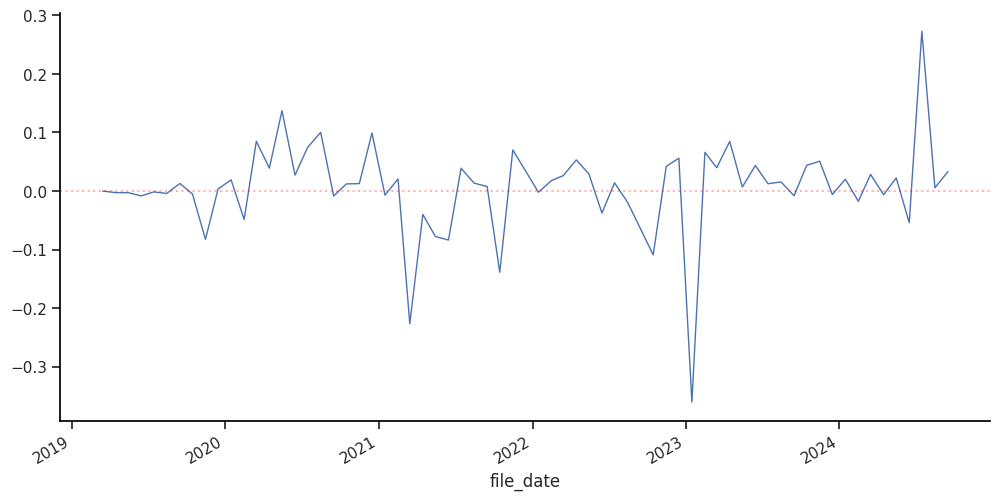

In [34]:
#when were the biggest changes?
plt.figure(figsize=(12, 6))
df_15_updates\
    .groupby(df_15_updates["file_date"])["Score_diff"]\
    .mean()\
    .plot(linewidth=1)
plt.axhline(0, color="red", linestyle=":", alpha=0.3)
custom_plots()

In [35]:
#filter out the ones that have never been updated
df_15_updates["Added"] = \
    df_15_updates\
        .apply(lambda row: pd.isna(row["Updated_diff"]), axis=1) #where there is no prior date to compare to

In [36]:
#Updated == True when time_diff is not 0 or not NaN
df_15_updates["Updated"] = \
    df_15_updates\
        .apply(lambda row: 
               not pd.isna(row["Updated_diff"]) and #added
               row["Updated_diff"] != pd.Timedelta(0), axis=1) #actual time difference

#df_15_updates.head(5)

In [37]:
added_df_15 = df_15_updates[df_15_updates["Added"] == True] #only the added ones 

added_counts = added_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Added")

added_means = added_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Added"})

added_sd = added_df_15\
    .groupby("file_date")["Score"]\
    .std()\
    .reset_index()\
    .rename(columns={"Score": "Std_Added"})

updates_summary = \
    updates_summary\
        .merge(added_counts, 
               on="file_date", 
               how="left")\
        .merge(added_means, 
               on="file_date", 
               how="left")\
        .merge(added_sd,
                on="file_date",
                how="left")

updates_summary.head(20)

,file_date,Count_All,Mean_All,Count_Added,Mean_Added,Std_Added
0,2019-03-15 01:00:00,2647,70.786424,2645,70.800421,35.314062
1,2019-04-15 01:00:00,2704,69.773596,61,25.144068,27.674844
2,2019-05-15 01:00:00,3047,71.042249,334,81.140673,20.359351
3,2019-06-15 01:00:00,3399,72.173881,365,82.238095,22.964602
4,2019-07-15 01:00:00,3611,72.550352,212,78.726829,23.207103
5,2019-08-15 01:00:00,3914,72.976265,304,77.943522,21.024513
6,2019-09-15 01:00:00,4129,72.637761,215,66.185714,30.631141
7,2019-10-15 01:00:00,4249,72.341583,120,62.222222,29.420733
8,2019-11-15 01:00:00,4420,71.721048,182,60.146409,29.893363
9,2019-12-15 01:00:00,4631,70.790524,211,51.152174,24.271018


In [38]:
#only the ones that were already in the database
included_df_15 = df_15_updates[df_15_updates["Added"] == False]

included_counts = included_df_15 \
    .groupby("file_date") \
        .size() \
    .reset_index(name="Count_Included")

included_means = included_df_15 \
    .groupby("file_date")["Score"] \
    .mean() \
    .reset_index() \
    .rename(columns={"Score": "Mean_Included"})

updates_summary = \
    updates_summary \
        .merge(included_counts, 
               on="file_date", 
               how="left") \
        .merge(included_means, 
               on="file_date", 
               how="left")

In [39]:
#updated/checked sources
updated_df_15 = df_15_updates[df_15_updates["Updated"] == True]

updated_counts = updated_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Updated")

updated_means = updated_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Updated"})

updates_summary = \
    updates_summary\
        .merge(updated_counts, 
               on="file_date", 
               how="left")\
        .merge(updated_means, 
               on="file_date", 
               how="left")

In [40]:
#included but not updated
not_updated_df_15 = included_df_15[included_df_15["Updated"] == False]

not_updated_counts = not_updated_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Not_Updated")

not_updated_means = not_updated_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Not_Updated"})

updates_summary = \
    updates_summary\
        .merge(not_updated_counts, 
               on="file_date", 
               how="left")\
        .merge(not_updated_means, 
               on="file_date", 
               how="left")

In [41]:
df_15_updates["Changed"] = df_15_updates\
    .apply(lambda row: 
           row["Score_diff"] != 0 and not pd.isna(row["Score_diff"]),
             axis=1)

changed_df_15 = df_15_updates[df_15_updates["Changed"] == True]


changed_counts = changed_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Changed")

changed_means = changed_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Changed"})

updates_summary = \
    updates_summary\
        .merge(changed_counts, 
               on="file_date", 
               how="left")\
        .merge(changed_means, 
               on="file_date", 
               how="left")

In [42]:
stable_df_15 = df_15_updates[(df_15_updates["Changed"] == False) & (df_15_updates["Updated"] == True)] #updated but never changed

#count number of sources per date
stable_counts = stable_df_15\
    .groupby("file_date")\
        .size()\
    .reset_index(name="Count_Stable")

stable_means = stable_df_15\
    .groupby("file_date")["Score"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score": "Mean_Stable"})

updates_summary = \
    updates_summary\
        .merge(stable_counts, 
               on="file_date", 
               how="left")\
        .merge(stable_means, 
               on="file_date", 
               how="left")
updates_summary

,file_date,Count_All,Mean_All,Count_Added,Mean_Added,Std_Added,Count_Included,Mean_Included,Count_Updated,Mean_Updated,Count_Not_Updated,Mean_Not_Updated,Count_Changed,Mean_Changed,Count_Stable,Mean_Stable
0,2019-03-15 01:00:00,2647,70.786424,2645,70.800421,35.314062,2,52.500000,2,52.500000,NaN,NaN,NaN,NaN,2,52.500000
1,2019-04-15 01:00:00,2704,69.773596,61,25.144068,27.674844,2643,70.782076,287,16.036842,2356.0,77.489897,16.0,68.343750,271,12.925651
2,2019-05-15 01:00:00,3047,71.042249,334,81.140673,20.359351,2713,69.809630,109,57.899083,2604.0,70.314786,5.0,83.400000,104,56.673077
3,2019-06-15 01:00:00,3399,72.173881,365,82.238095,22.964602,3034,70.973438,116,62.813043,2918.0,71.299514,20.0,75.950000,96,60.047368
4,2019-07-15 01:00:00,3611,72.550352,212,78.726829,23.207103,3399,72.172388,89,83.687500,3310.0,71.861741,36.0,87.625000,53,80.961538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2024-05-15 01:00:00,11733,64.036361,35,60.857143,31.643224,11698,64.044566,652,57.795349,11046.0,64.439583,79.0,60.778481,573,57.378975
62,2024-06-15 01:00:00,11998,62.895994,274,17.357414,23.882537,11724,63.997700,921,25.818281,10803.0,67.523312,118.0,47.389831,803,22.640449
63,2024-07-15 01:00:00,12097,62.946630,102,36.813725,25.901940,11995,63.186102,591,38.815567,11404.0,64.552609,187.0,58.930481,404,29.504950
64,2024-08-15 01:00:00,12187,62.934452,103,43.820513,35.926183,12084,63.000891,399,64.233418,11685.0,62.956271,97.0,66.628866,302,63.445763


In [43]:
#for each domain, what is the average time to get an update?
updated_time_means = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Updated_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Updated_diff": "Updated_mean"})

updated_time_means["Updated_mean"].describe()

count                          11076
mean     249 days 02:59:53.085485568
std      109 days 20:24:38.497982134
min                -1 days +19:00:00
25%         157 days 21:50:04.513550
50%      253 days 07:05:27.299937500
75%         334 days 07:52:03.756050
max         790 days 14:27:07.865000
Name: Updated_mean, dtype: object

In [44]:
#for each domain, what is the average change in score?
updated_means = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Score_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Score_diff": "Updated_mean"})

updated_means["Updated_mean"].describe()

count    10950.000000
mean         0.092739
std          3.519159
min        -50.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         55.000000
Name: Updated_mean, dtype: float64

In [45]:
#per domain, what is the number of times the score has actually changed?
score_changes = df_15_updates\
    .groupby(["Domain", "Country", "Language"])["Changed"]\
    .sum()\
    .reset_index()\
    .rename(columns={"Changed": "Score_changes_count"})

score_changes["Score_changes_count"].describe()

count    13093.00000
mean         0.63553
std          0.94707
min          0.00000
25%          0.00000
50%          0.00000
75%          1.00000
max          7.00000
Name: Score_changes_count, dtype: float64

In [46]:
#what is the time difference between actual score changes? 
actual_changes = df_15_updates[(df_15_updates["Changed"] == True) | (df_15_updates["Added"] == True)]

#difference in time
actual_changes["Actual_Updated_diff"] = actual_changes\
    .groupby(["Domain", "Country", "Language"])["Last Updated"]\
    .diff()

#calculate the average time between updates per domain
actual_updated_means = actual_changes\
    .groupby(["Domain", "Country", "Language"])["Actual_Updated_diff"]\
    .mean()\
    .reset_index()\
    .rename(columns={"Actual_Updated_diff": "Actual_Updated_mean"})

actual_updated_means["Actual_Updated_mean"].describe()

count                           5198
mean     576 days 01:00:27.386454888
std      305 days 05:07:55.594460512
min           6 days 04:14:43.022000
25%         397 days 00:56:26.091250
50%         472 days 13:58:34.039500
75%         676 days 21:35:29.790125
max        2154 days 04:04:06.859000
Name: Actual_Updated_mean, dtype: object

In [47]:
# show the row with the highest value in Score_diff
# actual_changes[actual_changes["Score_diff"] == actual_changes["Score_diff"].min()]

In [48]:
#make a bar chart with percentage of added vs updated and their mean score
updates_changed = updates_summary[["file_date", "Count_Added", "Mean_Added", "Count_Changed", "Mean_Changed"]]

#turn NaN into 0
updates_changed.fillna(0, inplace=True)
updates_changed["Count_All"] = updates_changed["Count_Added"] + updates_changed["Count_Changed"]
updates_changed["Mean_All"] = (updates_changed["Mean_Added"] + updates_changed["Mean_Changed"]) / 2
updates_changed["Percentage_Added"] = updates_changed["Count_Added"] / updates_changed["Count_All"]
updates_changed["Percentage_Changed"] = updates_changed["Count_Changed"] / updates_changed["Count_All"]
updates_changed

,file_date,Count_Added,Mean_Added,Count_Changed,Mean_Changed,Count_All,Mean_All,Percentage_Added,Percentage_Changed
0,2019-03-15 01:00:00,2645,70.800421,0.0,0.000000,2645.0,35.400210,1.000000,0.000000
1,2019-04-15 01:00:00,61,25.144068,16.0,68.343750,77.0,46.743909,0.792208,0.207792
2,2019-05-15 01:00:00,334,81.140673,5.0,83.400000,339.0,82.270336,0.985251,0.014749
3,2019-06-15 01:00:00,365,82.238095,20.0,75.950000,385.0,79.094048,0.948052,0.051948
4,2019-07-15 01:00:00,212,78.726829,36.0,87.625000,248.0,83.175915,0.854839,0.145161
...,...,...,...,...,...,...,...,...,...
61,2024-05-15 01:00:00,35,60.857143,79.0,60.778481,114.0,60.817812,0.307018,0.692982
62,2024-06-15 01:00:00,274,17.357414,118.0,47.389831,392.0,32.373622,0.698980,0.301020
63,2024-07-15 01:00:00,102,36.813725,187.0,58.930481,289.0,47.872103,0.352941,0.647059
64,2024-08-15 01:00:00,103,43.820513,97.0,66.628866,200.0,55.224689,0.515000,0.485000


In [49]:
count_values = pd.melt(updates_changed, id_vars='file_date', 
                       value_vars=['Count_Added', 'Count_Changed'], 
                       var_name='Count_Type', value_name='Count')
count_values["Count_Type"] = count_values["Count_Type"].str.replace("Count_", "")

count_values = count_values.rename(columns={"Count_Type": "Type"})
mean_values = pd.melt(updates_changed, id_vars='file_date', 
                      value_vars=['Mean_Added', 'Mean_Changed'], 
                      var_name='Mean_Type', value_name='Mean')
mean_values["Mean_Type"] = mean_values["Mean_Type"].str.replace("Mean_", "")
mean_values = mean_values.rename(columns={"Mean_Type": "Type"})

perc_values = pd.melt(updates_changed, id_vars='file_date',
                        value_vars=['Percentage_Added', 'Percentage_Changed'],
                        var_name='Percentage_Type', value_name='Percentage')
perc_values["Percentage_Type"] = perc_values["Percentage_Type"].str.replace("Percentage_", "")
perc_values = perc_values.rename(columns={"Percentage_Type": "Type"})


In [50]:
updates_long = pd.merge(count_values, mean_values, 
                        on=["file_date", "Type"], 
                        how='left')

updates_long = pd.merge(updates_long, perc_values,
                        on=["file_date", "Type"],
                        how='left')
updates_long.sort_values(by="file_date", inplace=True)
updates_long.head(4)

,file_date,Type,Count,Mean,Percentage
0,2019-03-15 01:00:00,Added,2645.0,70.800421,1.000000
66,2019-03-15 01:00:00,Changed,0.0,0.000000,0.000000
1,2019-04-15 01:00:00,Added,61.0,25.144068,0.792208
67,2019-04-15 01:00:00,Changed,16.0,68.343750,0.207792


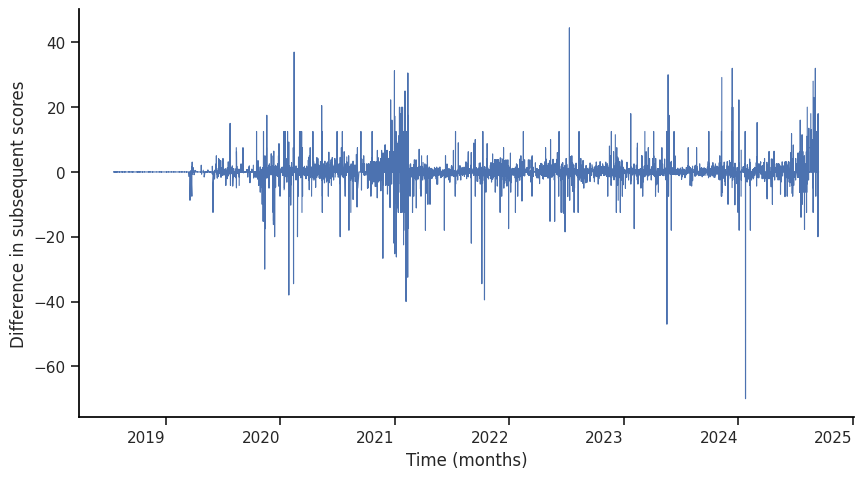

In [51]:
plt.figure(figsize=(10, 6))

df_15_updates\
    .groupby(["Last Updated"]).Score_diff\
    .mean()\
    .plot(linewidth=0.8)

plt.ylabel("Difference in subsequent scores")
plt.xlabel("Time (months)")
plt.xticks(rotation=0)
custom_plots()

plt.savefig(join(FIGURES, "score_updates.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

In [52]:
#updated_df_15\
#        .sort_values(
#            "Score_diff", ascending=True)\
#                [["Domain", "Score_diff", "Last Updated"]]\
#        .head(5)

## Figure 1

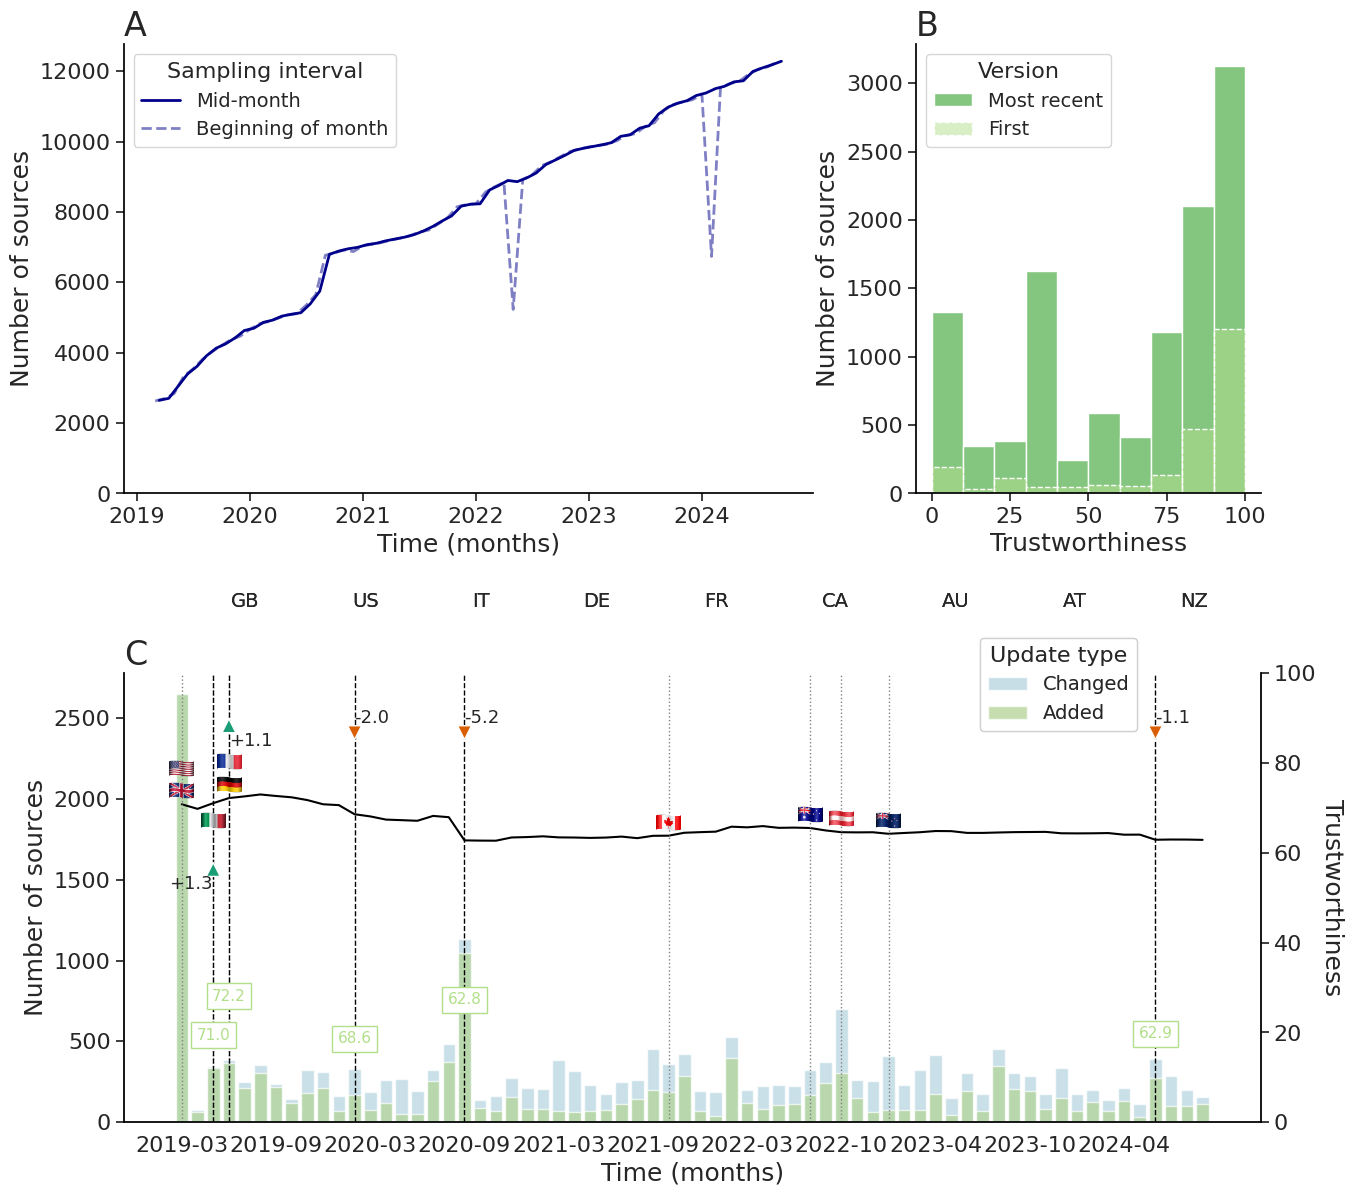

In [53]:
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(2, 3,
              width_ratios=[2, 1, 0],
              hspace=0.4,
              wspace=0.3
              )  

''' SUBPLOT A '''
ax1 = fig.add_subplot(gs[0, 0])
sns.lineplot(data=counts_15, 
             x="file_date", 
             y="Counts", 
             color="darkblue", 
             alpha=1, 
             linewidth=2, 
             label="Mid-month", 
             ax=ax1)

sns.lineplot(data=counts_02, 
             x="file_date", 
             y="Counts", 
             color="darkblue", 
             alpha=0.5, 
             linewidth=2, 
             linestyle="dashed", 
             label="Beginning of month", 
             ax=ax1)

ax1.tick_params(axis="x", labelsize=16)
ax1.tick_params(axis="y", labelsize=16)
ax1.set_ylim(0)
ax1.set_title("A", fontsize=24, loc="left")
ax1.set_xlabel("Time (months)", fontsize=18)
ax1.set_ylabel("Number of sources", fontsize=18)
ax1.legend(title="Sampling interval", 
           fontsize=14,
             title_fontsize=16)
custom_plots(ax=ax1)

''' SUBPLOT B '''
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(data=df_recent, x="Score", 
             bins=10,
             alpha=0.6, 
             edgecolor="white", 
             color="#33a02c",
             label="Most recent", 
             ax=ax2)

sns.histplot(data=df_first, x="Score", 
             bins=10, 
             edgecolor="white", 
             color= "#b2df8a",
             alpha=0.5, 
             linestyle="dashed", 
             label="First", 
             ax=ax2)

ax2.set_xlabel("Trustworthiness", fontsize=18)
ax2.set_ylabel("Number of sources", fontsize=18)
ax2.legend(fontsize=14,
           title="Version",
           title_fontsize=16)
ax2.set_title("B", fontsize=24, loc="left")
ax2.tick_params(axis="x", labelsize=16)
ax2.tick_params(axis="y", labelsize=16)
custom_plots(ax=ax2)

''' SUBPLOT C '''
#extract file_date and countries as dictionary
country_change_dict = country_change\
    .set_index("file_date")\
    .to_dict()["Added_Countries"]

#remove ALL
country_change_dict = {k: v.replace("ALL, ", "") for k, v in country_change_dict.items()}

ax3 = fig.add_subplot(gs[1, :2])  
ax3.set_title("C", fontsize=24, loc="left")

#barplot
updates_changed["file_date_month"] = \
    updates_changed["file_date"]\
        .dt.strftime('%Y-%m')\
            .astype(str)

sns.barplot(data=updates_changed, 
            x="file_date_month", 
            y="Count_All", 
            color="lightblue",
            label="Changed", 
            alpha=0.7, 
            ax=ax3)

sns.barplot(data=updates_changed, 
            x="file_date_month", 
            y="Count_Added", 
            color="#b2df8a", 
            alpha=0.7, 
            label="Added", 
            ax=ax3)

#barplot legend
handles, labels = ax3.get_legend_handles_labels()
added_changed_legend = plt.legend(handles,
                                  labels,
                                  loc="upper right", 
                                  bbox_to_anchor=(0.9, 1.1), 
                                  title="Update type", 
                                  title_fontsize=16,
                                  fontsize=14)

ax3.add_artist(added_changed_legend)

#settings for the first y-axis
ax3.spines["right"].set_visible(True)
ax3.yaxis.set_ticks_position("right")
ax3.grid(False)
ax3.set_ylabel("Number of sources", fontsize=18)
ax3.set_xlabel("Time (months)", fontsize=18)
ax3.tick_params("y", labelsize=16)
ax3.tick_params(axis="x", labelsize=16)
ax3.set_xticks(ax3.get_xticks()[::6])


ax4 = ax3.twinx()
country_count["file_date_month"] = \
    country_count["file_date"]\
        .dt.strftime('%Y-%m').astype(str)

sns.lineplot(data=country_count, 
             x="file_date_month", 
             y="Score", 
             color="black",
             ax=ax4)

country_change["file_date_month"] = \
    country_change["file_date"].dt\
        .strftime("%Y-%m")\
            .astype(str)

top_changes["Date_month"] = \
    top_changes["Date"].dt\
        .strftime("%Y-%m")\
            .astype(str)

for i, date in enumerate(country_change["file_date_month"]):
    ax4.axvline(date, color="grey", linestyle=":", linewidth=1)

top_changes = top_changes\
    .sort_values(by="Date_month")\
    .reset_index(drop=True)

for i, date in enumerate(top_changes["Date_month"]):
    ax4.axvline(date, color="black", linestyle="--", linewidth=1)
    score_diff = round(top_changes["Score_diff"].iloc[i], 1)
    text = f"+{score_diff}" if score_diff > 0 else str(score_diff)

    if i == 0 or i == 1:
        arrow_color = "#1b9e77"  #green
        arrowprops = dict(facecolor=arrow_color, 
                          shrink=0.06, 
                          headwidth=10, 
                          headlength=10, 
                          width=5)
        xy = (date, 58) if i == 0 else (date, 90)
        xytext = (date, 53) if i == 0 else (date, 85)
        ha = "right" if i == 0 else "left"
    else:
        arrow_color = "#d95f02"  # Orange
        arrowprops = dict(facecolor=arrow_color, 
                          shrink=0.06, 
                          headwidth=10, 
                          headlength=10, 
                          width=5)
        xy = (date, 85)
        xytext = (date, 90)
        ha = "left"
    
    ax4.annotate(text, xy=xy, xytext=xytext,
                 arrowprops=arrowprops, fontsize=13, 
                 ha=ha, va="center")
        
for i, date in enumerate(top_changes["Date_month"]):
    if i == 1:
        ax4.text(date, 28, 
                round(top_changes["Score"].iloc[i],1), 
                fontsize=11,
                bbox=dict(facecolor="white", 
                          edgecolor="#b2df8a"), 
                color="#b2df8a",
                va="center", 
                ha="center")
    else:
        ax4.text(date, (top_changes["Added"].iloc[i]/100)+17, 
                round(top_changes["Score"].iloc[i], 1), 
                fontsize=11,
                bbox=dict(facecolor="white", 
                          edgecolor="#b2df8a"), 
                color="#b2df8a",
                va="center", 
                ha="center")


y_positions = {}
country_change_dict_str = \
    {pd.to_datetime(key)\
     .strftime("%Y-%m"): value for key, value in country_change_dict.items()}

for date, countries in country_change_dict_str.items():
    for idx, country in enumerate(countries.split(", ")):
        flag_path = f"flags/{country}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {country} not found.")
            continue
        flag = plt.imread(flag_path)
        country_x = date
        country_score = country_count.loc[country_count["file_date_month"] == date, "Score"].iloc[0]
        if country == "IT":
            y_position = country_score + idx - 4
        else:
            if date in y_positions:
                y_position = country_score + idx + 7
            else:
                y_position = country_score + idx + 3
        imagebox = OffsetImage(flag, zoom=0.4)
        ab = AnnotationBbox(imagebox, (country_x, y_position), frameon=False)
        ax4.add_artist(ab)
        y_positions.setdefault(date, []).append(y_position)

legend_elements = []
for country in country_change_dict.values():
    for c in country.split(", "):
        flag_path = f"flags/{c}.png"
        if not os.path.exists(flag_path):
            print(f"Flag for {c} not found.")
            continue
        flag = plt.imread(flag_path)
        legend_elements.append(ax3.plot([], [], linestyle="none", label=c)[0])

legends_flags = ax4.legend(handles=legend_elements, loc="lower center", 
                           bbox_to_anchor=(0.5, 1.1), 
                           frameon=False,
                           fontsize=14, ncol=9, title_fontsize=16)
ax4.add_artist(legends_flags)

ax4.set_ylabel("Trustworthiness", 
               rotation=270,
               #whitespace
                labelpad=20,
               fontsize=18)
ax4.tick_params(axis="y", labelsize=16)
ax4.set_ylim(0, 100)
ax4.grid(False)

#common settings
ax3.spines["top"].set_visible(False)
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_color("black")
ax4.spines["left"].set_color("black")
ax4.spines["bottom"].set_color("black")

plt.savefig(join(FIGURES, 
                 "trustworthiness_panel.pdf"), 
                 bbox_inches='tight', pad_inches=0.1,
                 dpi=300)

plt.show()

## What is the composition of the overall trustworthiness score?

In [54]:
#rename variable name
criteria_recent_list = [
                    "Does not repeatedly publish false or egregiously misleading content",
                    "Gathers and presents information responsibly",
                    "Has effective practices for correcting errors",
                    "Handles the difference between news and opinion responsibly",
                    "Avoids deceptive headlines",
                    "Website discloses ownership and financing",
                    "Clearly labels advertising",
                    "Reveals who's in charge, including any possible conflicts of interest",
                    "The site provides names of content creators, along with either contact or biographical information"] 

criteria_recent_list_numbers = [
                    "1 - Does not repeatedly publish false or egregiously misleading content",
                    "2 - Gathers and presents information responsibly",
                    "3 - Has effective practices for correcting errors",
                    "4 - Handles the difference between news and opinion responsibly",
                    "5 - Avoids deceptive headlines",
                    "6 - Website discloses ownership and financing",
                    "7 - Clearly labels advertising",
                    "8 - Reveals who's in charge, including any possible conflicts of interest",
                    "9 - The site provides names of content creators, along with either contact or biographical information"] 

In [55]:
#subset criteria and file_date
df_criteria_recent = df_recent[criteria_recent_list]
df_criteria_recent.columns = range(1,10)
df_criteria_recent = df_criteria_recent.astype(str)

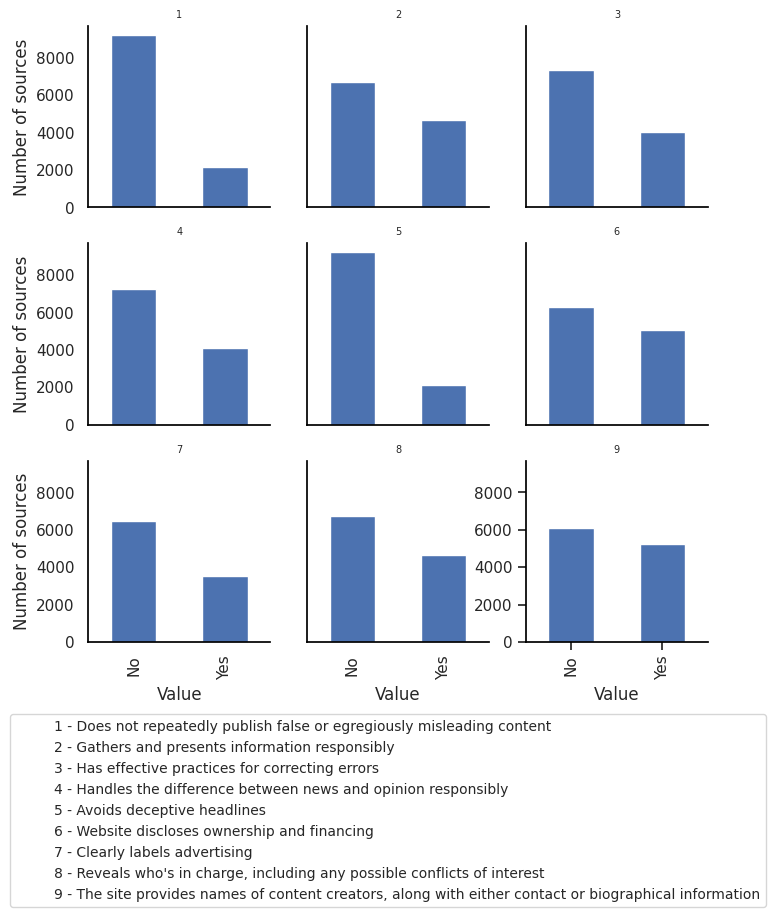

In [56]:
def plot_yesno(df):
    fig, axs = plt.subplots(nrows=3, 
                            ncols=3, 
                            sharex=True,
                            sharey=True,
                            figsize=(8, 8))

    for i, col in enumerate(df.columns):
        row = i // 3 
        col_in_row = i % 3 
        df[col] = df[col].replace("nan", np.nan)
        df[col]\
            .value_counts()\
            .plot(kind="bar",
                  ax=axs[row, col_in_row])
        axs[row, col_in_row].set_xlabel("Value")
        axs[row, col_in_row].set_ylabel("Number of sources")
        axs[row, col_in_row].set_title(f"{col}", fontsize=7)
        custom_plots(ax=axs[row, col_in_row])

    handles = [plt.Line2D([0,1],[0,1], 
                          linestyle="none", 
                          marker = " ", 
                          color="black") for _ in criteria_recent_list_numbers]
    labels = criteria_recent_list_numbers
    fig.legend(handles, labels, loc="lower center", bbox_to_anchor=(0.5, -0.23), 
               fontsize="small")
        
    plt.show()

plot_yesno(df_criteria_recent)

In [57]:
df_recent_critera = pd.melt(df_criteria_recent, 
                      value_vars=df_criteria_recent, 
                      var_name="Criteria", 
                      value_name="Label")
criteria_counts = df_recent_critera\
                    .groupby(["Criteria", "Label"])\
                    .size()\
                    .unstack(fill_value=0)\
                    .reset_index()

criteria_counts["Total"] = criteria_counts["Yes"] + criteria_counts["No"]
criteria_counts["Yes%"] = criteria_counts["Yes"] / criteria_counts["Total"] * 100
criteria_counts["No%"] = criteria_counts["No"] / criteria_counts["Total"] * 100

criteria_counts.sort_values(by="Yes", ascending=False)

Label,Criteria,No,Yes,Total,Yes%,No%
4,5,2119,9217,11336,81.307339,18.692661
0,1,2138,9211,11349,81.161336,18.838664
3,4,4068,7213,11281,63.939367,36.060633
7,8,4640,6707,11347,59.108134,40.891866
1,2,4653,6696,11349,59.000793,40.999207
6,7,3512,6474,9986,64.830763,35.169237
8,9,6093,5220,11313,46.141607,53.858393
5,6,6274,5075,11349,44.717596,55.282404
2,3,7319,4029,11348,35.504054,64.495946


In [58]:
df_criteria_recent = \
    df_criteria_recent\
        .replace({"Yes": 1, "No": 0})\
        .fillna(0)

cooccurrence = \
    df_criteria_recent\
        .T\
        .dot(df_criteria_recent)
cooccurrence

/tmp/ipykernel_598056/722380647.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1, "No": 0})\


,1,2,3,4,5,6,7,8,9
1,9211.0,6696.0,4025.0,6876.0,9049.0,4788.0,5892.0,5704.0,4873.0
2,6696.0,6696.0,3837.0,6179.0,6683.0,4506.0,5010.0,5345.0,4547.0
3,4025.0,3837.0,4029.0,3717.0,4014.0,2936.0,3383.0,3185.0,3235.0
4,6876.0,6179.0,3717.0,7213.0,6905.0,4514.0,5337.0,5343.0,4566.0
5,9049.0,6683.0,4014.0,6905.0,9217.0,4821.0,5841.0,5770.0,4940.0
6,4788.0,4506.0,2936.0,4514.0,4821.0,5075.0,3932.0,4205.0,3362.0
7,5892.0,5010.0,3383.0,5337.0,5841.0,3932.0,6474.0,4428.0,3834.0
8,5704.0,5345.0,3185.0,5343.0,5770.0,4205.0,4428.0,6707.0,4283.0
9,4873.0,4547.0,3235.0,4566.0,4940.0,3362.0,3834.0,4283.0,5220.0


In [59]:
#correlation matrix
corr = df_criteria_recent.corr()
corr = corr.round(2).map(lambda x: '{:.2g}'.format(x))
corr

,1,2,3,4,5,6,7,8,9
1,1,0.63,0.4,0.56,0.93,0.38,0.39,0.26,0.36
2,0.63,1,0.57,0.75,0.63,0.58,0.49,0.55,0.56
3,0.4,0.57,1,0.48,0.4,0.45,0.44,0.34,0.53
4,0.56,0.75,0.48,1,0.57,0.52,0.51,0.47,0.5
5,0.93,0.63,0.4,0.57,1,0.39,0.37,0.28,0.39
6,0.38,0.58,0.45,0.52,0.39,1,0.42,0.48,0.4
7,0.39,0.49,0.44,0.51,0.37,0.42,1,0.29,0.36
8,0.26,0.55,0.34,0.47,0.28,0.48,0.29,1,0.47
9,0.36,0.56,0.53,0.5,0.39,0.4,0.36,0.47,1


In [60]:
#save as latex table
corr.to_latex(join(TABLES, "criteria_correlation_recent.tex"))

In [61]:
#exploratory factor analysis of criteria
chi_square_value,p_value=calculate_bartlett_sphericity(df_criteria_recent)
chi_square_value, p_value # there is a significant correlation among the variables

(69416.25359479531, 0.0)

In [62]:
#squared partial correlations
kmo_all,kmo_model=calculate_kmo(df_criteria_recent)
kmo_model #adequate sample size (larger than 0.5)

/home/jluehring/miniconda3/envs/newsguard/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


0.8566177982722266

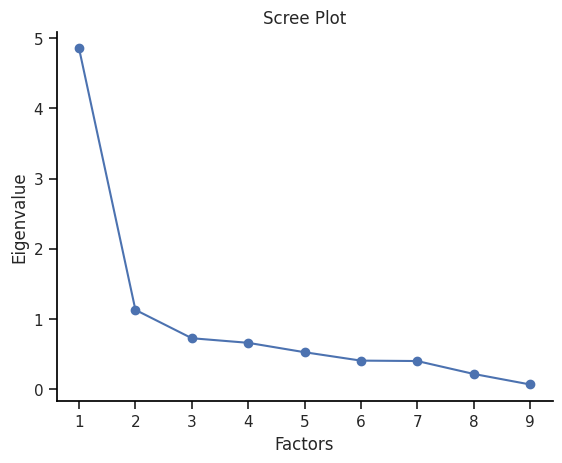

In [63]:
fa = FactorAnalyzer(rotation=None)
fa.fit(df_criteria_recent, 25)
ev, v = fa.get_eigenvalues()

# screeplot
plt.scatter(range(1,df_criteria_recent.shape[1]+1),ev)
plt.plot(range(1,df_criteria_recent.shape[1]+1),ev)
plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
custom_plots()
plt.show()


# 2 factors have eigenvalues > 1

In [64]:
fa = FactorAnalyzer(n_factors=2, 
                    rotation="oblimin")
fa.fit(df_criteria_recent)
loadings = fa.loadings_
loadings_df = pd.DataFrame(loadings, 
                           index=df_criteria_recent.columns)
loadings_df

,0,1
1,-0.014955,1.006665
2,0.770605,0.175793
3,0.657330,0.008282
4,0.682050,0.169983
5,0.069440,0.885740
6,0.700413,-0.043083
7,0.532049,0.073968
8,0.740270,-0.186320
9,0.713719,-0.060622


In [65]:
#variance explained
fa.get_factor_variance()[0]

array([3.3272013 , 1.90349344])

In [66]:
#in percentage
fa.get_factor_variance()[2]*100

array([36.96890333, 58.11883044])

In [67]:
#multiple combinations of criteria
combinations = df_criteria_recent\
                .groupby(df_criteria_recent.columns\
                         .tolist())\
                .size()\
                .reset_index(name="Counts")

combinations["Percentage"] = \
    combinations["Counts"]/(df_recent["Score"].count())*100

combinations\
    .sort_values("Counts", ascending=False)\
    .head(3)

,1,2,3,4,5,6,7,8,9,Counts,Percentage
211,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1537,13.543043
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1521,13.402062
70,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1341,11.816019


In [68]:
#multiple combinations of criteria
combinations = df_criteria_recent\
                .groupby(df_criteria_recent.columns\
                         .tolist())\
                .size()\
                .reset_index(name="Counts")

combinations["Percentage"] = \
    combinations["Counts"]/(df_recent["Score"].count())*100

combinations\
    .sort_values("Counts", ascending=False)\
    .head(10)

,1,2,3,4,5,6,7,8,9,Counts,Percentage
211,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1537,13.543043
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1521,13.402062
70,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1341,11.816019
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,549,4.837431
177,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,490,4.317561
203,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,480,4.229448
176,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,457,4.026787
165,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,389,3.427615
210,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,338,2.978236
209,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,337,2.969425


### How have criteria changed over time?

In [69]:
criteria_all_list = [
       "Does not repeatedly publish false content",
       "Does not repeatedly publish false or egregiously misleading content",
       "Gathers and presents information responsibly",
       "Regularly corrects or clarifies errors",
       "Has effective practices for correcting errors",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information"]

In [70]:
counts_data = []

for column in criteria_all_list:
    column_counts = df_15\
                        .groupby("file_date")[column]\
                        .count()\
                        .reset_index()
    column_counts = column_counts\
                        .rename(columns={column: "count"})
    column_counts["criteria"] = column
    counts_data.append(column_counts)

counts_table = pd.concat(counts_data, ignore_index=True)

counts_table = counts_table[["file_date", "criteria", "count"]]

first_ratings = counts_table[counts_table["count"] > 0]

first_ratings = first_ratings\
    .groupby("criteria")\
        .agg(
            min_date=("file_date", "min"),
            max_date=("file_date", "max"))\
    .reset_index()

first_ratings

,criteria,min_date,max_date
0,Avoids deceptive headlines,2019-03-15 01:00:00,2024-09-15 01:00:00
1,Clearly labels advertising,2019-03-15 01:00:00,2024-09-15 01:00:00
2,Does not repeatedly publish false content,2019-03-15 01:00:00,2023-11-15 01:00:00
3,Does not repeatedly publish false or egregiously misleading content,2023-12-15 01:00:00,2024-09-15 01:00:00
4,Gathers and presents information responsibly,2019-03-15 01:00:00,2024-09-15 01:00:00
5,Handles the difference between news and opinion responsibly,2019-03-15 01:00:00,2024-09-15 01:00:00
6,Has effective practices for correcting errors,2023-12-15 01:00:00,2024-09-15 01:00:00
7,Regularly corrects or clarifies errors,2019-03-15 01:00:00,2023-11-15 01:00:00
8,"Reveals who's in charge, including any possible conflicts of interest",2019-03-15 01:00:00,2024-09-15 01:00:00
9,"The site provides names of content creators, along with either contact or biographical information",2019-03-15 01:00:00,2024-09-15 01:00:00


In [71]:
df_criteria_15 = df_15[
       ["Does not repeatedly publish false content",
       "Does not repeatedly publish false or egregiously misleading content",
       "Gathers and presents information responsibly",
       "Regularly corrects or clarifies errors",
       "Has effective practices for correcting errors",
       "Handles the difference between news and opinion responsibly",
       "Avoids deceptive headlines",
       "Website discloses ownership and financing",
       "Clearly labels advertising",
       "Reveals who's in charge, including any possible conflicts of interest",
       "The site provides names of content creators, along with either contact or biographical information"]
       ]

In [72]:
#criteria changes over time 
df_15 = df_15\
        .replace({"Yes": 1, 
                  "No": 0})

criteria_avg = df_15\
    .groupby("file_date")[criteria_all_list]\
    .sum()

#collapse two columns and calculate mean
criteria_avg["Does not repeatedly publish false or egregiously misleading content"] = \
    criteria_avg[[
        "Does not repeatedly publish false content", 
        "Does not repeatedly publish false or egregiously misleading content"]]\
    .mean(axis=1)

criteria_avg["Has effective practices for correcting errors"] = \
    criteria_avg[[
        "Regularly corrects or clarifies errors", 
        "Has effective practices for correcting errors"]]\
    .mean(axis=1)

criteria_avg = \
    criteria_avg.drop(columns=[
        "Does not repeatedly publish false content",
        "Regularly corrects or clarifies errors"])

criteria_avg.columns = \
    [f"{i + 1} - {col}" for i, col in enumerate(criteria_avg.columns)]

/tmp/ipykernel_598056/1525396100.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1,


In [73]:
#calculate the total number per year
criteria_sum = criteria_avg\
    .reset_index()\
    .melt(id_vars="file_date", 
          value_vars=criteria_avg.columns, 
          var_name="Criteria", 
          value_name="Count")

criteria_sum = criteria_sum\
    .groupby("file_date")["Count"]\
    .sum()\
    .reset_index(name="Total")

#merge 
criteria_avg = criteria_avg\
    .merge(criteria_sum, 
           on="file_date")

In [74]:
#standardize by number of sources per month 
n_sources_month = df_15\
    .groupby("file_date")\
    .size()\
    .reset_index(name="N")

#merge
criteria_avg = criteria_avg\
    .merge(n_sources_month, 
           on="file_date")

#standardize criteria columns by number of sources 
for column in criteria_avg.columns[1:11]:
    criteria_avg[column] = criteria_avg[column] / criteria_avg["N"] * 100

criteria_avg.head(3)

,file_date,1 - Does not repeatedly publish false or egregiously misleading content,2 - Gathers and presents information responsibly,3 - Has effective practices for correcting errors,4 - Handles the difference between news and opinion responsibly,5 - Avoids deceptive headlines,6 - Website discloses ownership and financing,7 - Clearly labels advertising,"8 - Reveals who's in charge, including any possible conflicts of interest","9 - The site provides names of content creators, along with either contact or biographical information",Total,N
0,2019-03-15 01:00:00,39.516434,71.212694,26.917265,67.434832,73.517189,57.725727,80.204005,66.981488,64.185871,547.695504,2647
1,2019-04-15 01:00:00,39.127219,69.970414,26.497781,66.124260,72.226331,56.360947,79.326923,66.715976,63.054734,539.404586,2704
2,2019-05-15 01:00:00,39.990154,71.808336,26.206104,68.231047,74.236954,57.630456,80.275681,67.804398,60.846734,547.029865,3047


In [75]:
#turn into year fomat
criteria_avg["file_year"] = criteria_avg["file_date"].dt.year

#drop the date
criteria_avg = criteria_avg.drop(columns=["file_date"])

#aggregate per year
criteria_avg_year = criteria_avg\
    .groupby("file_year")\
    .mean()

criteria_avg_year

,1 - Does not repeatedly publish false or egregiously misleading content,2 - Gathers and presents information responsibly,3 - Has effective practices for correcting errors,4 - Handles the difference between news and opinion responsibly,5 - Avoids deceptive headlines,6 - Website discloses ownership and financing,7 - Clearly labels advertising,"8 - Reveals who's in charge, including any possible conflicts of interest","9 - The site provides names of content creators, along with either contact or biographical information",Total,N
file_year,,,,,,,,,,,
2019,40.494189,72.646755,25.745466,69.192883,76.104560,57.577744,80.100355,68.585957,57.311751,547.759659,3675.100000
2020,39.646235,64.036724,22.266910,64.025721,76.367077,48.235201,69.692691,63.366285,48.434443,496.071288,5711.833333
2021,40.004910,59.776122,20.190487,61.182020,78.816205,44.308445,60.305352,60.503352,44.508398,469.595291,7526.166667
2022,40.572612,61.862501,20.214641,64.129406,80.948647,47.680464,61.769662,60.766364,46.405552,484.349848,9088.636364
2023,39.943600,59.683151,18.949857,63.396739,80.742492,44.409517,57.480321,59.247211,46.226334,470.079221,10524.000000
2024,37.779793,55.938052,16.981470,59.938804,76.501794,42.312718,53.660379,55.808516,43.870502,442.792027,11830.666667


In [76]:
#subset the first entry and the updates only
df_15_criteria_updates = \
    df_15_updates[df_15_updates["Added"] | df_15_updates["Updated"]]

#recode criteria columns recent to 1 and 0
df_15_criteria_updates = df_15_criteria_updates\
    .replace({"Yes": 1, "No": 0})

#collapse the two columns
df_15_criteria_updates["Does not repeatedly publish false or egregiously misleading content"] = \
    df_15_criteria_updates[["Does not repeatedly publish false content", 
                "Does not repeatedly publish false or egregiously misleading content"]]\
    .max(axis=1)

df_15_criteria_updates["Has effective practices for correcting errors"] = \
    df_15_criteria_updates[["Regularly corrects or clarifies errors", 
                "Has effective practices for correcting errors"]]\
    .max(axis=1)

df_15_criteria_updates = \
    df_15_criteria_updates.drop(columns=[
        "Does not repeatedly publish false content",
        "Regularly corrects or clarifies errors"])

/tmp/ipykernel_598056/1791637028.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1, "No": 0})


In [77]:
for criterion in criteria_recent_list:
    df_15_criteria_updates[f'Diff_{criterion}'] = \
        df_15_criteria_updates\
            .groupby(["Domain", "Country", "Language"])[criterion]\
            .diff()
    df_15_criteria_updates[f'Diff_{criterion}'] = \
        df_15_criteria_updates[f'Diff_{criterion}']
    
    #df_15_criteria_updates.head(10)

In [78]:
df_15_criteria_updates["Updated_Any_Criterion"] = \
    df_15_criteria_updates\
        .apply(lambda row: 
               any(row[f'Diff_{c}'] != 0 and 
                   not pd.isna(row[f'Diff_{c}']) 
                   for c in criteria_recent_list),
                axis=1)

In [79]:
#per domain, count the number of times the criteria have changed
criteria_domain_changes = df_15_criteria_updates\
    .groupby(["Domain", "Country", "Language"])["Updated_Any_Criterion"]\
    .sum()\
    .reset_index()\
    .rename(columns={"Updated_Any_Criterion": "Criteria_changes_count"})

#how many zeros?
criteria_domain_changes["Criteria_changes_count"]\
    .value_counts(
        normalize=True)

Criteria_changes_count
0    0.602994
1    0.233865
2    0.104025
3    0.043993
4    0.012602
5    0.002062
6    0.000382
7    0.000076
Name: proportion, dtype: float64

In [80]:
df_15_criteria_diffs = df_15_criteria_updates[
    [col for col in df_15_criteria_updates.columns 
     if col.startswith("Diff_")]]

In [81]:
criteria_change = \
    df_15_criteria_diffs\
        .mean()\
        .reset_index()\
        .rename(columns={"index": "Criteria", 
                         0: "Avg Change"})

total_change = df_15_criteria_diffs\
                    .astype(bool)\
                    .sum()

negative_changes = (df_15_criteria_diffs < 0).sum()
positive_changes = (df_15_criteria_diffs > 0).sum()

negative_changes_percentage = \
    (negative_changes / df_15_criteria_updates.Domain.nunique() * 100)\
    .round(2)


positive_changes_percentage = \
    (positive_changes / df_15_criteria_updates.Domain.nunique() * 100)\
    .round(2)

criteria_changes = pd.DataFrame({
    "Criteria": criteria_change["Criteria"],
    "Total Change": total_change.values,
    "Avg. Change": criteria_change["Avg Change"],
    "Negative Changes": negative_changes_percentage.values,
    "Positive Changes": positive_changes_percentage.values}
    )

criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .str.replace("Diff_", "")

criteria_changes.sort_values(by="Total Change")

,Criteria,Total Change,Avg. Change,Negative Changes,Positive Changes
0,Does not repeatedly publish false or egregiously misleading content,14010,0.003730,0.91,2.62
1,Gathers and presents information responsibly,14044,-0.000457,2.02,1.81
4,Avoids deceptive headlines,14080,0.002324,1.38,2.44
3,Handles the difference between news and opinion responsibly,14653,0.004055,2.49,4.34
7,"Reveals who's in charge, including any possible conflicts of interest",14934,-0.000019,5.79,5.78
8,"The site provides names of content creators, along with either contact or biographical information",15402,0.004746,6.41,8.58
2,Has effective practices for correcting errors,15805,0.001523,9.22,9.92
5,Website discloses ownership and financing,16251,-0.003350,12.28,10.74
6,Clearly labels advertising,19552,-0.013489,10.10,4.43


In [82]:
#df_15_criteria_updates\
#    [df_15_criteria_updates["Diff_Website discloses ownership and financing"] == -1]\
#    ["Domain"].unique()

## How complete is the database across countries?

In [83]:
#drop the ALL category
df_recent_countries = df_recent[df_recent["Country"] != "ALL"]

In [84]:
lang = df_recent_countries\
    .groupby("Language")\
    .size()\
    .reset_index()

lang\
    .columns = ["Language", "n"]

lang["%"] = \
    (lang["n"] / lang["n"].sum()) * 100

lang

,Language,n,%
0,de,410,3.768729
1,en,9455,86.910562
2,fr,477,4.384594
3,it,537,4.936115


In [85]:
countries_lang = df_recent_countries\
    .groupby(["Country", "Language"])\
    .size()\
    .reset_index()

countries_lang\
    .columns = ["Country", "Language", "n"]

countries_lang["\%"] = \
    round((countries_lang["n"] / len(df_recent_countries)) *100, 1)

countries_lang

<>:9: SyntaxWarning: invalid escape sequence '\%'
<>:9: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_598056/1711312843.py:9: SyntaxWarning: invalid escape sequence '\%'
  countries_lang["\%"] = \


,Country,Language,n,\%
0,AT,de,42,0.4
1,AU,en,166,1.5
2,CA,en,418,3.8
3,CA,fr,53,0.5
4,DE,de,368,3.4
5,FR,fr,424,3.9
6,GB,en,568,5.2
7,IT,it,537,4.9
8,NZ,en,22,0.2
9,US,en,8281,76.1


In [86]:
#save table as latex >turn into function for later tables?
countries_lang_latex = countries_lang \
    .sort_values("n", ascending=False) \
    .to_latex(
        index=False, 
        escape=False,
        caption="\\textbf{Country Descriptives.}",
        label="table:countries_language", 
        position='H',
        column_format=' X c c c c',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
countries_lang_latex = \
    countries_lang_latex\
    .replace("\\end{tabular}", "\\end{tabularx}")

countries_lang_latex = \
    countries_lang_latex\
    .replace("\\bottomrule", "\\bottomrule\n\\textit{Note.} As of September 15th, 2024.")

with open(join(TABLES, 
               "countries_language.tex"), 'w') as f:
    f.write(countries_lang_latex)

In [87]:
country_means = \
    df_recent_countries\
        .groupby("Country")\
        .agg({"Score": ["mean", "std", "size"]})\
        .reset_index()\
        .round(1)

country_means\
    .columns = ["Country", "Score_mean", "Score_std", "n"]

country_means["Trustworthiness (SD)"] = \
    country_means\
        .apply(lambda row: f'{row["Score_mean"]} ({row["Score_std"]})', 
               axis=1)

country_means = \
    country_means\
        .drop(["Score_mean", "Score_std"], 
              axis=1)

#percentage
country_means["%"] = \
    (country_means["n"] / len(df_recent_countries) * 100)\
        .round(1)

#order
country_means = \
    country_means\
        .sort_values("n", ascending=False)\
        .reset_index(drop=True)

country_means["n (\%)"] = \
    country_means\
        .apply(lambda row: f'{row["n"]} ({row["%"]})', 
               axis=1)

country_means = \
    country_means\
        .drop("%", 
              axis=1)

#reorder columns
country_means = \
    country_means[["Country", "n (\%)", 
                   "Trustworthiness (SD)"]]

country_means

<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:44: SyntaxWarning: invalid escape sequence '\%'
<>:32: SyntaxWarning: invalid escape sequence '\%'
<>:44: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_598056/1104712091.py:32: SyntaxWarning: invalid escape sequence '\%'
  country_means["n (\%)"] = \
/tmp/ipykernel_598056/1104712091.py:44: SyntaxWarning: invalid escape sequence '\%'
  country_means[["Country", "n (\%)",


,Country,n (\%),Trustworthiness (SD)
0,US,8281 (76.1),56.8 (34.1)
1,GB,568 (5.2),78.5 (23.5)
2,IT,537 (4.9),70.9 (24.2)
3,CA,471 (4.3),87.7 (15.3)
4,FR,424 (3.9),65.4 (29.2)
5,DE,368 (3.4),77.0 (31.2)
6,AU,166 (1.5),72.5 (24.6)
7,AT,42 (0.4),77.2 (29.6)
8,NZ,22 (0.2),76.3 (24.7)


In [88]:
df_15_countries = df_15[df_15["Country"] != "ALL"]
country_score_time = df_15_countries\
    .groupby(["Country","file_date"])\
    .agg({"Score": ["mean", "std"]})\
    .reset_index()
country_score_time.columns = ["Country", "file_date", "Score", "SD"]

In [89]:
country_score_count = df_15_countries\
    .groupby(["file_date", "Country"])\
    .size()\
    .reset_index(name="Count")

country_score_time = country_score_time\
    .merge(country_score_count, 
           on=["Country", "file_date"])

country_score_time

,Country,file_date,Score,SD,Count
0,AT,2022-10-15 01:00:00,71.437500,31.951496,25
1,AT,2022-11-15 01:00:00,71.437500,31.951496,25
2,AT,2022-12-15 01:00:00,71.903846,30.821103,27
3,AT,2023-01-15 01:00:00,69.982143,32.148522,29
4,AT,2023-02-15 01:00:00,73.090909,30.565620,34
...,...,...,...,...,...
423,US,2024-05-15 01:00:00,58.161771,33.798273,7813
424,US,2024-06-15 01:00:00,56.606808,34.420013,8064
425,US,2024-07-15 01:00:00,56.803269,34.252442,8120
426,US,2024-08-15 01:00:00,56.780721,34.269746,8196


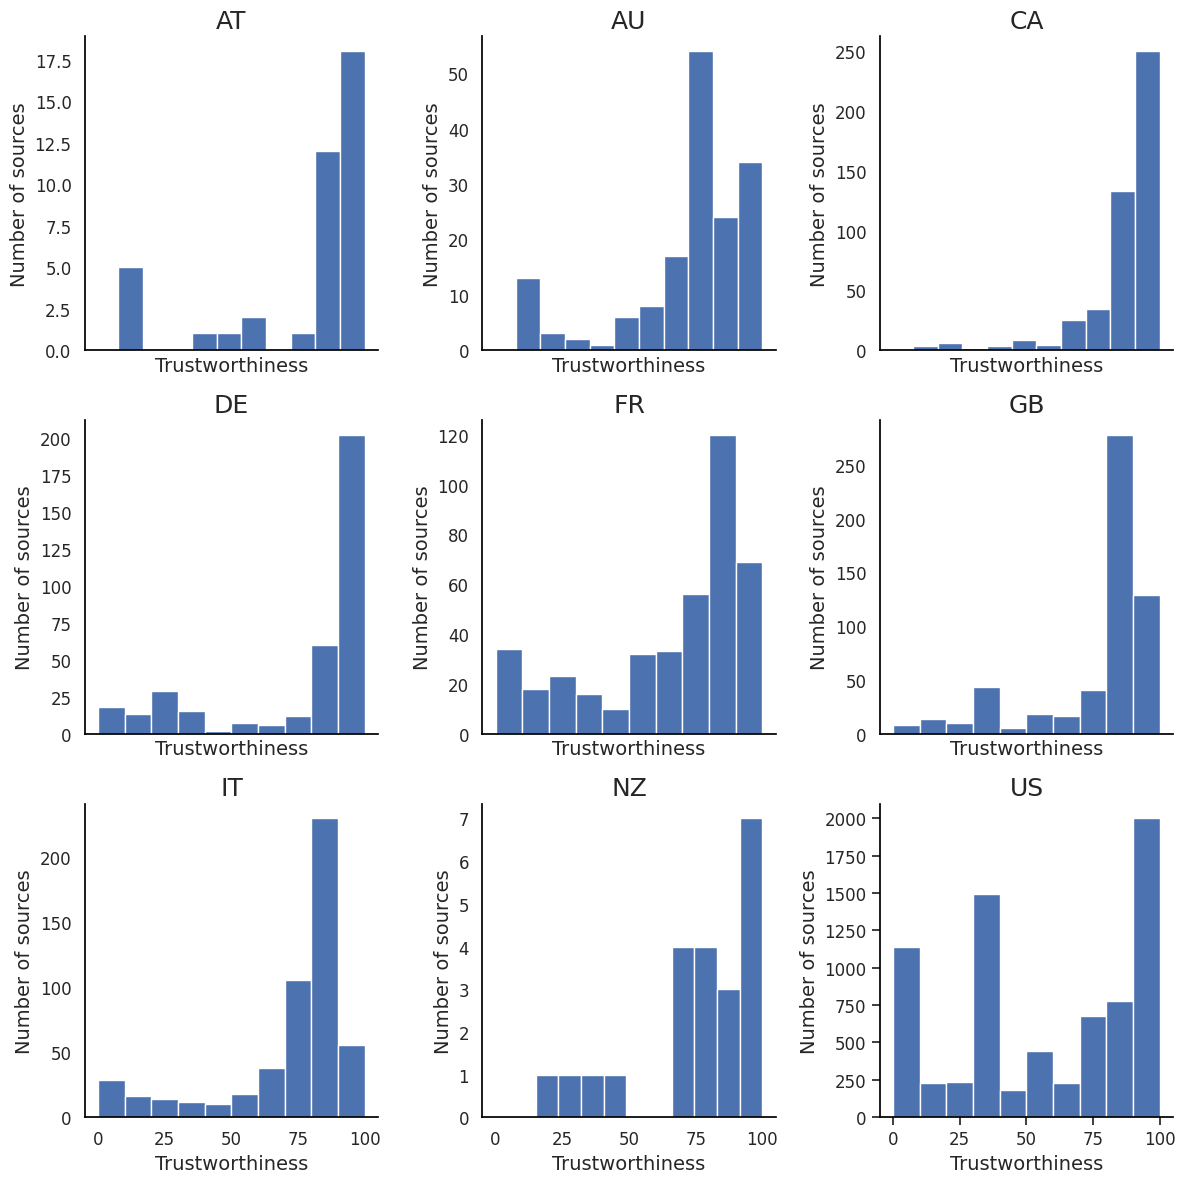

In [90]:
fig, axs = plt.subplots(nrows=3, ncols=3, 
                        figsize=(12, 12), 
                        sharey=False, 
                        sharex=True)

plt.subplots_adjust(hspace=0.7, wspace=0.7)

#get a list of country names and order them alphabetically
countries_list = df_recent_countries["Country"]\
                    .unique()\
                    .tolist()

countries_list = sorted(countries_list)

for i, country in enumerate(countries_list):
    row = i // 3 
    col_in_row = i % 3  
    df = df_recent_countries[df_recent_countries["Country"] == country]
    df["Score"].hist(ax=axs[row, col_in_row])
    axs[row, col_in_row].set_xlabel("Trustworthiness", fontsize=14)
    axs[row, col_in_row].set_ylabel("Number of sources", fontsize=14)
    axs[row, col_in_row].set_title(f'{country}', fontsize=18)
    axs[row, col_in_row].tick_params(axis="both", labelsize=12)
    custom_plots(ax=axs[row, col_in_row])

plt.tight_layout()
plt.savefig(join(FIGURES,"scores_per_country_recent.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

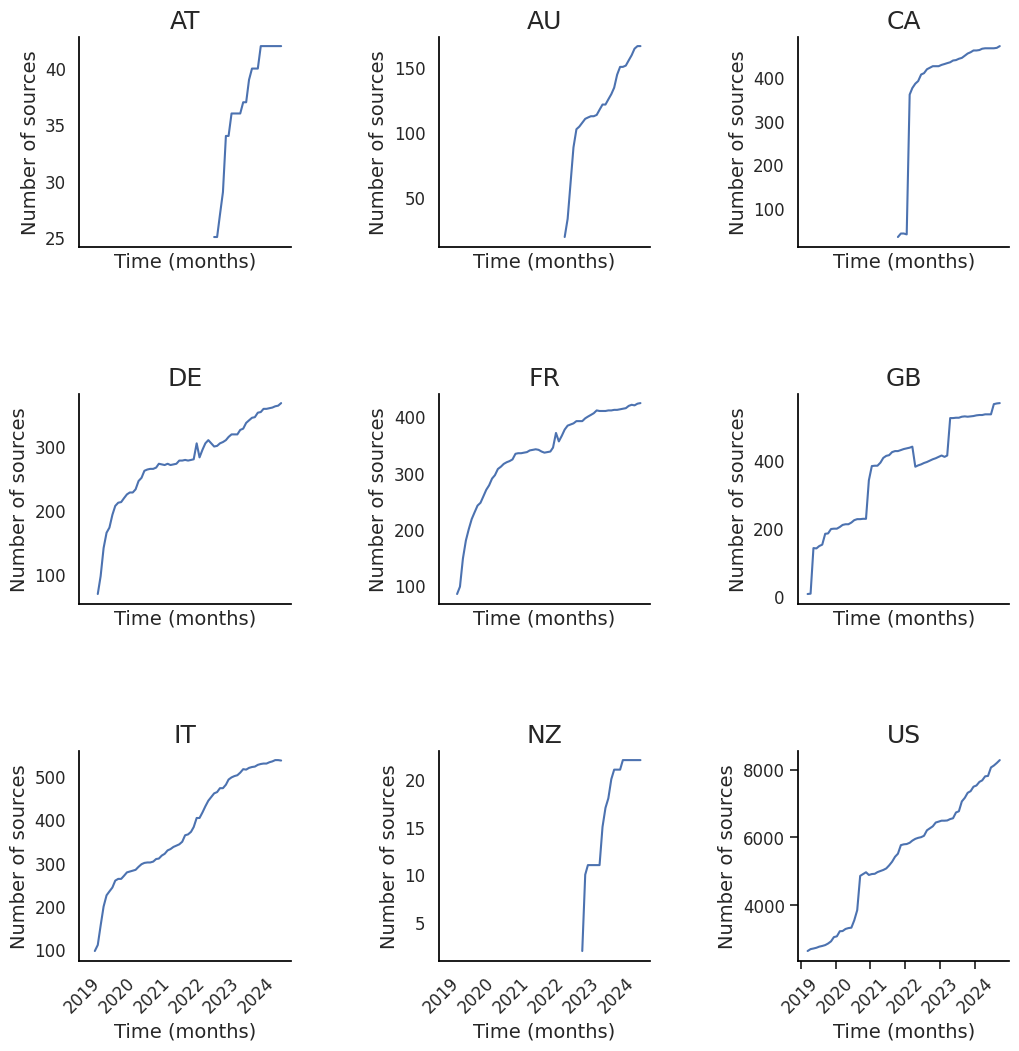

In [91]:
#do the same with the number of domains over time
country_domains = df_15_countries\
    .groupby(["Country","file_date"])\
    .size()\
    .reset_index(name="Count")

fig, axs = plt.subplots(nrows=3, ncols=3, 
                        figsize=(12, 12), 
                        sharey=False, 
                        sharex=True)

plt.subplots_adjust(hspace=0.7, wspace=0.7)

for i, country in enumerate(countries_list):
    row = i // 3 
    col_in_row = i % 3  
    df = country_domains[country_domains["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Count"], label=country)
    axs[row, col_in_row].set_xlabel("Time (months)", fontsize=14)
    axs[row, col_in_row].set_ylabel("Number of sources", fontsize=14)
    axs[row, col_in_row].set_title(f'{country}', fontsize=18)
    axs[row, col_in_row].tick_params(axis="x", labelsize=12, rotation=45)
    axs[row, col_in_row].tick_params(axis="y", labelsize=12)
    custom_plots(ax=axs[row, col_in_row])

plt.savefig(join(FIGURES,"n_sources_per_country_over_time.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

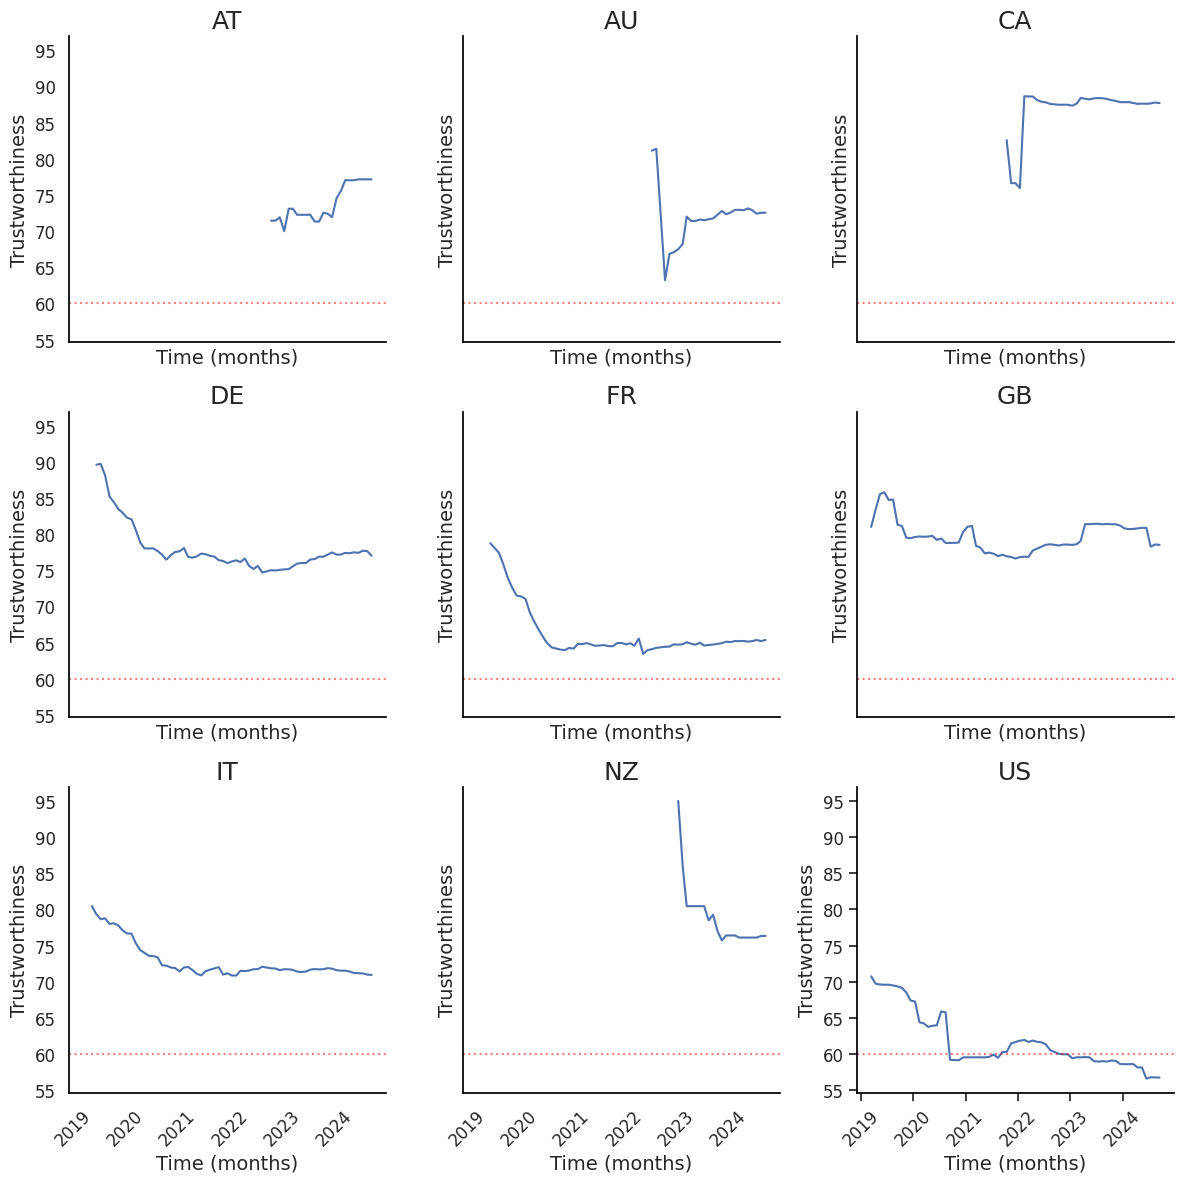

In [92]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12), sharey=True, sharex=True)
plt.subplots_adjust(hspace=0.7, wspace=0.7)

for i, country in enumerate(countries_list):
    row = i // 3 
    col_in_row = i % 3  
    df = country_score_time[country_score_time["Country"] == country]  
    axs[row, col_in_row].plot(df["file_date"], df["Score"], 
                              label=country)
    axs[row, col_in_row].set_xlabel("Time (months)", fontsize=14)
    axs[row, col_in_row].set_ylabel("Trustworthiness", fontsize=14)
    axs[row, col_in_row].set_title(f'{country}', fontsize=18)
    axs[row, col_in_row].tick_params(axis="x", labelsize=12, rotation=45)
    axs[row, col_in_row].tick_params(axis="y", labelsize=12)
    axs[row, col_in_row].axhline(y=60, color="red", linestyle="dotted", 
                                 alpha=0.5, label="Trustworthiness threshold")
    custom_plots(ax=axs[row, col_in_row])

plt.tight_layout()

plt.savefig(join(FIGURES,"scores_per_country_over_time.pdf"), 
            bbox_inches='tight', 
            pad_inches=0.1,
            dpi=300)
plt.show()

### What are the criteria per country?

In [93]:
df_recent_countries = df_recent_countries\
        .replace({"Yes": 1, 
                  "No": 0})

criteria_country_sum = df_recent_countries\
    .groupby("Country")\
    [criteria_recent_list]\
    .sum()\
    .reset_index()

sources_country_count = \
    df_recent_countries\
        .groupby("Country")\
        .size()\
        .reset_index(name="Total")

criteria_country_sum = \
    criteria_country_sum\
        .merge(sources_country_count, 
               on="Country")

/tmp/ipykernel_598056/292571118.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace({"Yes": 1,


In [94]:
#make table with percentages
criteria_country_perc = criteria_country_sum.copy()

for col in criteria_recent_list:
    criteria_country_perc[col] = \
        round(criteria_country_perc[col] / criteria_country_perc["Total"] * 100, 1)

criteria_country_perc\
    .drop(columns="Total", 
          inplace=True)

criteria_country_perc\
    .set_index("Country", inplace=True)

criteria_country = \
    criteria_country_perc\
        .transpose()\
            .reset_index()

criteria_country\
    .rename(columns={"index": "Criteria"}, 
            inplace=True)

criteria_weights = [22, 18, 12.5, 12.5, 10, 7.5, 7.5, 5, 5]

criteria_weights_df = pd.DataFrame({
    "Criteria": criteria_recent_list,
    "Weight": criteria_weights
})

criteria_country = criteria_country\
    .merge(criteria_weights_df, 
           on="Criteria")

criteria_country["Criteria"] = \
    criteria_country["Criteria"] + " (" + \
    criteria_country["Weight"].astype(str) + ")"

#drop weight
criteria_country = criteria_country\
    .drop(columns="Weight")

def insert_line_breaks(text, n=6):
    words = text.split()
    lines = [" ".join(words[i:i+n]) for i in range(0, len(words), n)]
    return " \\\\ ".join(lines)

criteria_country["Criteria"] = criteria_country["Criteria"].apply(insert_line_breaks)

criteria_country

,Criteria,AT,AU,CA,DE,FR,GB,IT,NZ,US
0,Does not repeatedly publish false or \\ egregiously misleading content (22.0),83.3,86.1,96.4,79.6,76.9,92.4,85.7,86.4,70.0
1,Gathers and presents information responsibly (18.0),76.2,80.7,93.6,73.9,62.0,80.8,79.1,81.8,43.6
2,Has effective practices for correcting errors \\ (12.5),54.8,34.3,79.0,62.5,25.9,28.5,15.5,54.5,30.4
3,Handles the difference between news and \\ opinion responsibly (12.5),73.8,78.3,94.9,79.6,69.3,81.7,75.6,90.9,48.9
4,Avoids deceptive headlines (10.0),83.3,85.5,97.2,81.2,78.1,93.5,87.0,95.5,69.5
5,Website discloses ownership and financing (7.5),69.0,53.6,52.9,73.6,56.8,74.3,67.2,54.5,29.8
6,Clearly labels advertising (7.5),92.9,50.6,88.1,79.6,56.1,78.5,74.3,72.7,42.8
7,"Reveals who's in charge, including any \\ possible conflicts of interest (5.0)",69.0,57.8,63.7,87.0,75.5,76.1,79.0,50.0,44.2
8,"The site provides names of content \\ creators, along with either contact or \\ biographical information (5.0)",28.6,59.0,69.0,52.2,30.9,71.8,25.1,36.4,41.3


In [95]:
criteria_country_latex = criteria_country\
    .to_latex(
        index=False, 
        escape=False,
        caption="Criteria per country.",
        label="tab:criteria_country", 
        position='H',
        column_format=' l X X X X X X X X X X ',
        longtable=False,
        header=True,
        na_rep='---',
        bold_rows=True)

criteria_country_latex = \
    criteria_country_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")
criteria_country_latex = \
    criteria_country_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

criteria_country_latex = \
    criteria_country_latex\
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of September 15th, 2024. Weights in brackets.}"
                 )

with open(join(TABLES, "criteria_country.tex"), 'w') as f:
    f.write(criteria_country_latex)

### How often do sources per country get updated?

In [96]:
#take average per domain
updated_country = updated_df_15\
    .groupby(["Domain", "Country", "Language"])["Updated_diff"]\
    .mean()\
    .reset_index()

#average per country
time_diff_country = updated_country\
    .groupby("Country")["Updated_diff"]\
    .mean()\
    .reset_index()

#remove ALL
time_diff_country = \
    time_diff_country[
        time_diff_country["Country"] != "ALL"]

#turn into day format
time_diff_country["Updated"] = \
    time_diff_country["Updated_diff"].dt.days

In [97]:
changed_country = actual_changes\
    .groupby(["Domain", 
              "Country", 
              "Language"])\
                ["Actual_Updated_diff"]\
    .mean()\
    .reset_index()

#changed_country per country
actual_time_diff = changed_country\
    .groupby("Country")["Actual_Updated_diff"]\
    .mean()\
    .reset_index()

#remove ALL
actual_time_diff = \
    actual_time_diff[
        actual_time_diff["Country"] != "ALL"]

#turn into day format and keep "days"
actual_time_diff["Changed"] = \
    actual_time_diff["Actual_Updated_diff"].dt.days

In [98]:
score_diff_per_domain = \
    updated_df_15\
        .groupby(["Country", 
                  "Domain", 
                  "Language"])\
                    ["Score_diff"]\
                        .mean()\
                            .reset_index()

score_diff_per_domain.groupby("Country")["Score_diff"]\
                        .mean()\
                        .reset_index()

,Country,Score_diff
0,ALL,0.522450
1,AT,3.057796
2,AU,-0.321895
3,CA,0.928295
4,DE,0.852977
5,FR,0.555967
6,GB,-0.478016
7,IT,0.191528
8,NZ,-1.875000
9,US,-0.058090


In [99]:
#merge time_diff_per_country with country_means
country_means_diff = country_means\
                    .merge(time_diff_country.filter(["Country", "Updated"]), 
                           on="Country")

country_means_diff = country_means_diff\
                       .merge(actual_time_diff.filter(["Country", "Changed"]), 
                               on="Country")

#rename columns 
country_means_diff = country_means_diff\
                    .rename(columns={"Updated_diff": "Updated", 
                                     "Actual_Updated_diff": "Changed"})
country_means_diff

,Country,n (\%),Trustworthiness (SD),Updated,Changed
0,US,8281 (76.1),56.8 (34.1),224,559
1,GB,568 (5.2),78.5 (23.5),224,474
2,IT,537 (4.9),70.9 (24.2),291,661
3,CA,471 (4.3),87.7 (15.3),306,430
4,FR,424 (3.9),65.4 (29.2),326,646
5,DE,368 (3.4),77.0 (31.2),308,673
6,AU,166 (1.5),72.5 (24.6),331,358
7,AT,42 (0.4),77.2 (29.6),338,375
8,NZ,22 (0.2),76.3 (24.7),313,426


In [100]:
#add "days" as string to Updated and Changed columns
country_means_diff["Updated"] = \
    country_means_diff["Updated"].astype(str) + " days"

country_means_diff["Changed"] = \
    country_means_diff["Changed"].astype(str) + " days"

country_means_latex = country_means_diff\
    .to_latex(
        index=False, 
        escape=False,
        caption="Country descriptives.",
        label="table:countries", 
        position='H',
        column_format=' X c c c c c ',
        longtable=False, 
        header=True, 
        na_rep='---', 
        bold_rows=True)

country_means_latex = \
    country_means_latex\
        .replace("\\begin{tabular}{", "\\begin{tabularx}{\\textwidth}{")

country_means_latex = \
    country_means_latex\
        .replace("\\end{tabular}", "\\end{tabularx}")

country_means_latex = \
    country_means_latex \
        .replace("\\bottomrule", 
                 "\\bottomrule\n" 
                 "\\multicolumn{3}{l}{\\textit{Note.} As of September 15th, 2024. Sorted by size.}"
                 )

with open(join(TABLES, "countries.tex"), 'w') as f:
    f.write(country_means_latex)

In [101]:
#make table with percentages
#copy the dataframe
criteria_country_miss = criteria_country_sum.copy()
#drop ALL
criteria_country_miss = criteria_country_miss[
    criteria_country_miss["Country"] != "ALL"]

for col in criteria_recent_list:
    criteria_country_miss[col] = \
        criteria_country_miss["Total"] - criteria_country_miss[col] 
    
for col in criteria_recent_list:
    criteria_country_miss[col] = \
        round(criteria_country_miss[col] / criteria_country_miss["Total"] * 100, 1)

criteria_country_miss\
    .drop(columns="Total", 
          inplace=True)

#set country as index
criteria_country_miss\
    .set_index("Country", inplace=True)

#replace column names with list
criteria_country_miss\
    .columns = criteria_recent_list_numbers


criteria_country_miss = criteria_country_miss\
    .reset_index()\
    .melt(id_vars="Country", 
          value_vars=criteria_recent_list_numbers, 
          var_name="Criteria", 
          value_name="Percentage")

criteria_country_miss["Criteria_num"] = \
    criteria_country_miss["Criteria"].str.extract("(\d+)")

criteria_country_miss

<>:37: SyntaxWarning: invalid escape sequence '\d'
<>:37: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_598056/1181985079.py:37: SyntaxWarning: invalid escape sequence '\d'
  criteria_country_miss["Criteria"].str.extract("(\d+)")


,Country,Criteria,Percentage,Criteria_num
0,AT,1 - Does not repeatedly publish false or egregiously misleading content,16.7,1
1,AU,1 - Does not repeatedly publish false or egregiously misleading content,13.9,1
2,CA,1 - Does not repeatedly publish false or egregiously misleading content,3.6,1
3,DE,1 - Does not repeatedly publish false or egregiously misleading content,20.4,1
4,FR,1 - Does not repeatedly publish false or egregiously misleading content,23.1,1
...,...,...,...,...
76,FR,"9 - The site provides names of content creators, along with either contact or biographical information",69.1,9
77,GB,"9 - The site provides names of content creators, along with either contact or biographical information",28.2,9
78,IT,"9 - The site provides names of content creators, along with either contact or biographical information",74.9,9
79,NZ,"9 - The site provides names of content creators, along with either contact or biographical information",63.6,9


In [102]:
criteria_country_miss.sort_values(by="Country", ascending=False).head(9)

,Country,Criteria,Percentage,Criteria_num
80,US,"9 - The site provides names of content creators, along with either contact or biographical information",58.7,9
44,US,5 - Avoids deceptive headlines,30.5,5
35,US,4 - Handles the difference between news and opinion responsibly,51.1,4
53,US,6 - Website discloses ownership and financing,70.2,6
8,US,1 - Does not repeatedly publish false or egregiously misleading content,30.0,1
26,US,3 - Has effective practices for correcting errors,69.6,3
71,US,"8 - Reveals who's in charge, including any possible conflicts of interest",55.8,8
62,US,7 - Clearly labels advertising,57.2,7
17,US,2 - Gathers and presents information responsibly,56.4,2


## Figure 2

In [103]:
#bar chart with change percentages
#change the label of one of the criteria
criteria_changes["Criteria"] = \
    criteria_changes["Criteria"]\
        .replace({"Does not repeatedly publish false or egregiously misleading content": 
                   "1",
                   "Gathers and presents information responsibly":
                    "2",
                    "Has effective practices for correcting errors":
                    "3",
                   "Handles the difference between news and opinion responsibly":
                   "4",
                   "Avoids deceptive headlines":
                    "5",
                    "Website discloses ownership and financing":
                    "6",
                    "Clearly labels advertising":
                    "7",
                    "Reveals who's in charge, including any possible conflicts of interest":
                    "8",
                   "The site provides names of content creators, along with either contact or biographical information":
                   "9"
                   })

#reshape negative and positive change to long format
criteria_changes = \
    criteria_changes.melt(
        id_vars=["Criteria"],
        value_vars=["Negative Changes", "Positive Changes"],
        var_name="Change",
        value_name="Value")


criteria_changes =\
    criteria_changes.sort_values(
        by="Value", 
        ascending=False)

/tmp/ipykernel_598056/1364213682.py:102: UserWarning: Rasterization of 'AxesHostAxes(0.547727,0.461522;0.352273x0.418478)' will be ignored
  cbar_ax.set_rasterized(True)


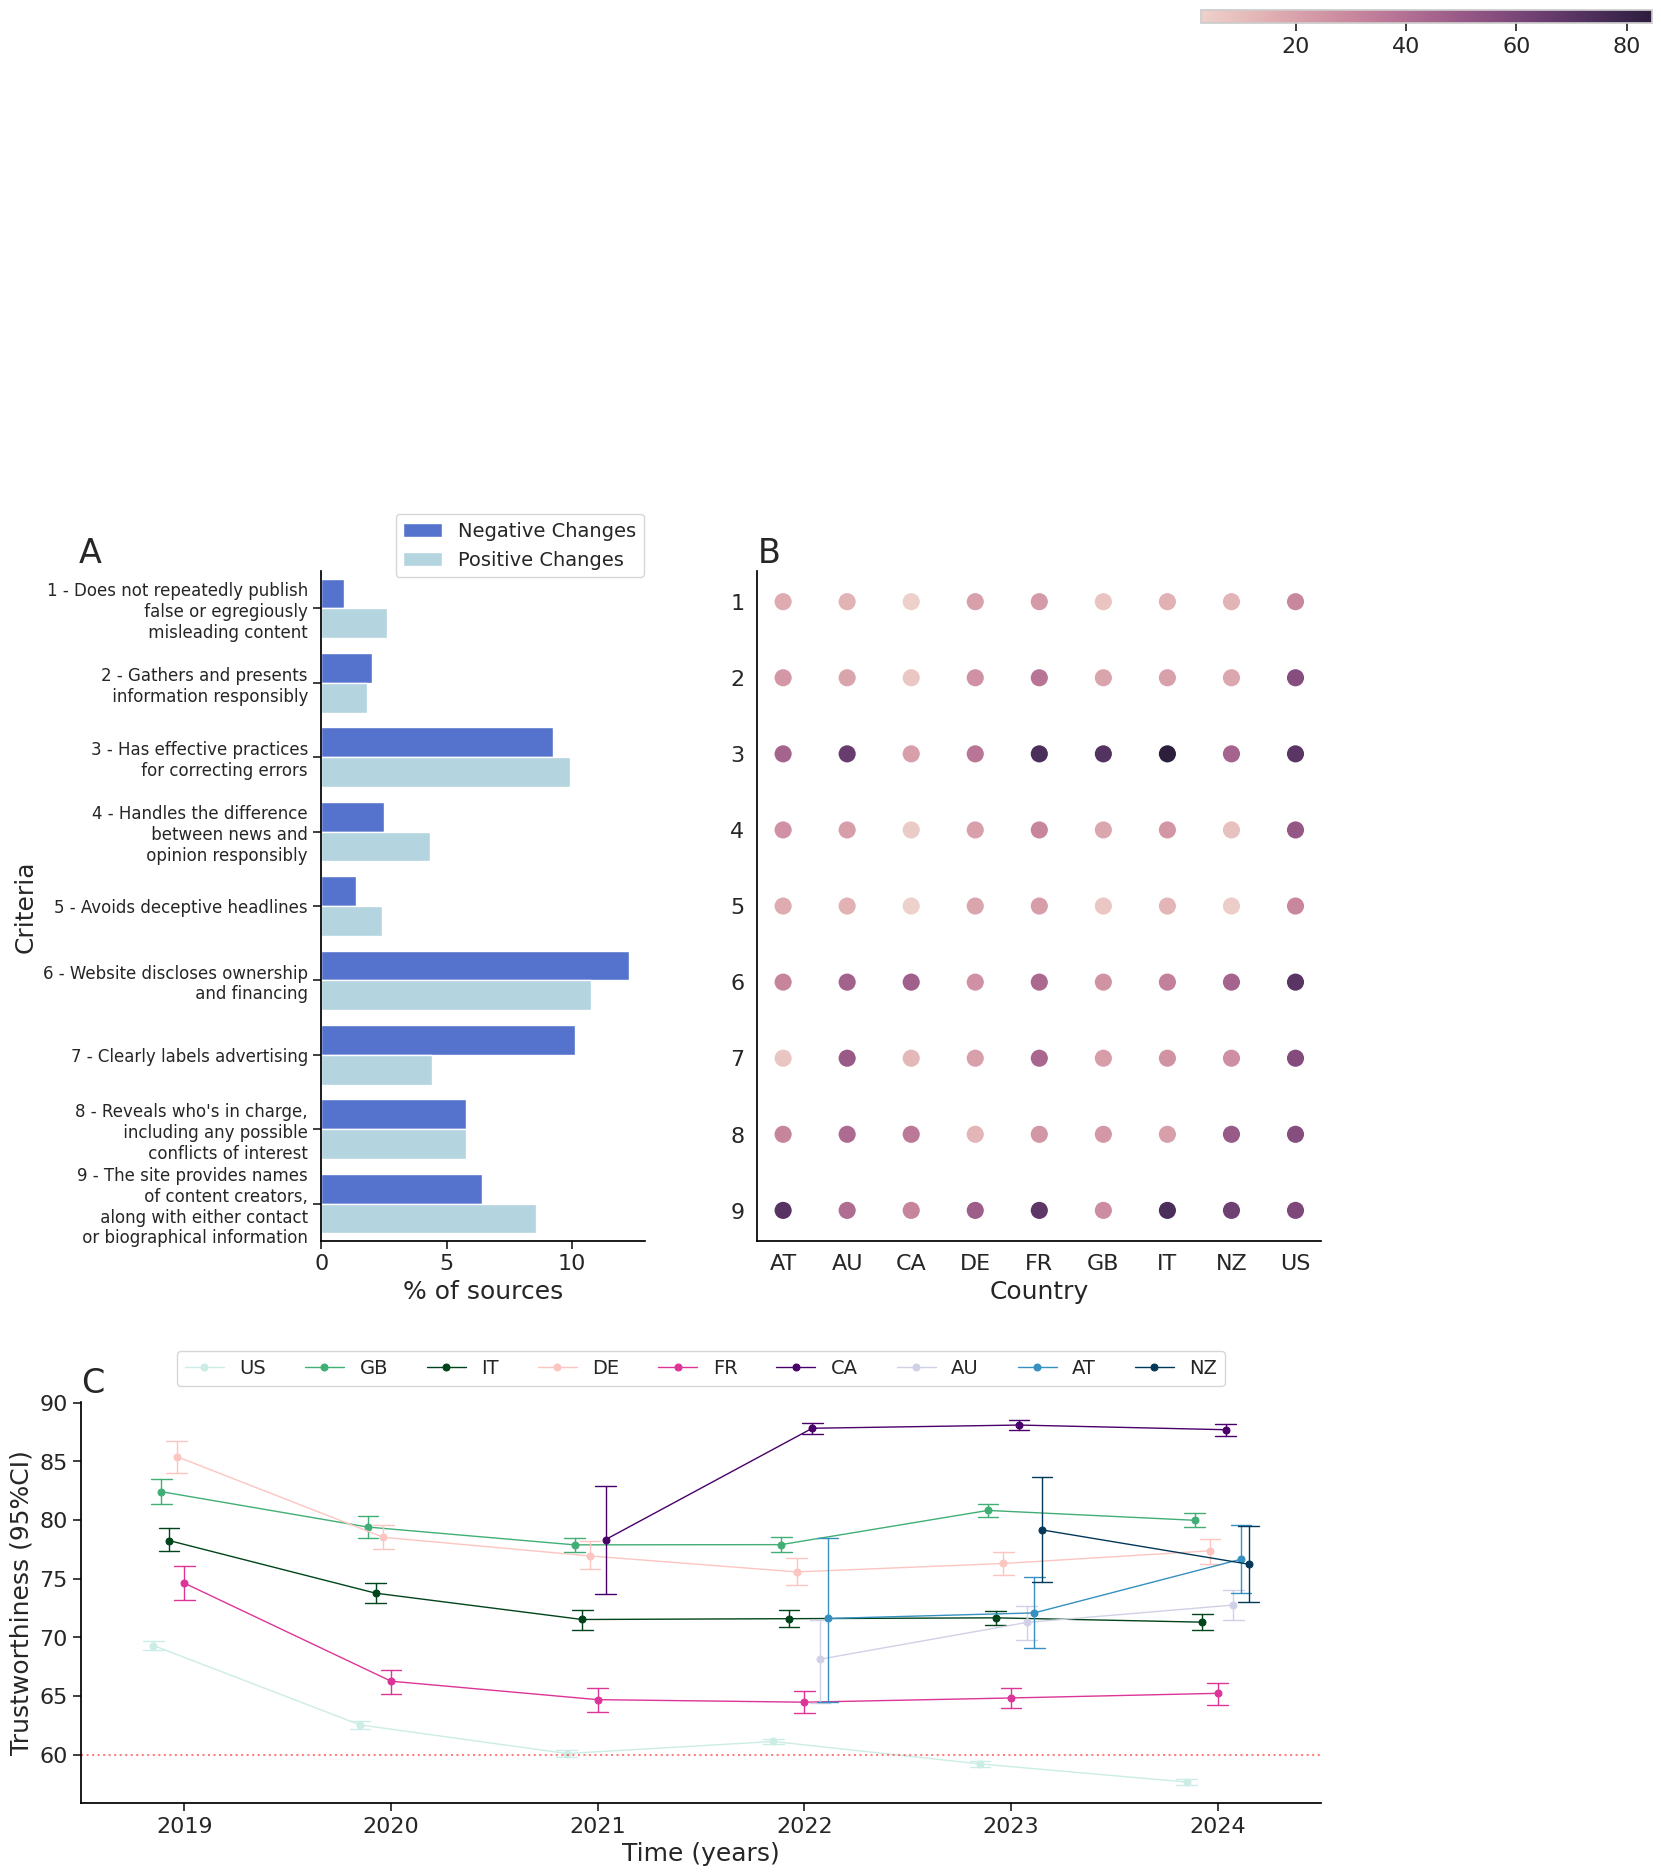

In [104]:
country_palette = ['#ccece6','#41ae76','#00441b', '#fcc5c0','#dd3497','#49006a', '#d0d1e6','#3690c0','#023858']
country_markers = ["o", "s", "^", "D", "v", "p", "h", "8", ">", "<"]
country_linestyles = ["-", "--", "-.", ":", "-", "--", "-.", ":", "-", "--"]

fig = plt.figure(figsize=(16, 16))
gs = GridSpec(2, 2,
              width_ratios=[1, 1],
              height_ratios=[1.25, 0.75],
              hspace=0.3)  

''' SUBPLOT A '''
ax0 = fig.add_subplot(gs[0, 0])

ax0.set_title("A", fontsize=24, 
              loc="left",
              #manually set location
                x=-0.75, y=1)

left_margin = 0.15
pos = ax0.get_position()
ax0.set_position([pos.x0 + left_margin, pos.y0, pos.width - left_margin, pos.height])

#order criteria by criteria
criteria_changes = criteria_changes\
    .sort_values(by="Criteria")

criteria_mapping = {
    "1":"1 - Does not repeatedly publish\n false or egregiously\n misleading content",
    "2":"2 - Gathers and presents\n information responsibly",
    "3":"3 - Has effective practices\n for correcting errors",
    "4":"4 - Handles the difference\n between news and\n opinion responsibly",
    "5":"5 - Avoids deceptive headlines",
    "6":"6 - Website discloses ownership\n and financing",
    "7":"7 - Clearly labels advertising",
    "8":"8 - Reveals who's in charge,\n including any possible\n conflicts of interest",
    "9":"9 - The site provides names\n of content creators,\n along with either contact\n or biographical information"
}

criteria_change_leg = criteria_changes.replace({"Criteria": criteria_mapping})

sns.barplot(data=criteria_change_leg, 
            x="Value", 
            y="Criteria", 
            hue="Change",
            palette={"Negative Changes": year_colors[3], 
                     "Positive Changes": year_colors[2]},
            ax=ax0
            )

ax0.set_xlabel("% of sources", fontsize=18)
ax0.set_ylabel("Criteria", fontsize=18)
ax0.tick_params(axis="y", labelsize=12)
ax0.legend(fontsize=14,
           loc="upper left",
           bbox_to_anchor=(0.2, 1.1))
custom_plots(ax=ax0)


''' SUBPLOT B '''
ax1 = fig.add_subplot(gs[0, 1])

#order criteria by criteria
criteria_country_miss = criteria_country_miss\
    .sort_values(by="Criteria_num")

sns.scatterplot(data=criteria_country_miss,
                x="Country",
                y="Criteria_num",
                hue="Percentage",
                palette = sns.cubehelix_palette(as_cmap=True),
                s=180,
                ax=ax1)

ax1.set_xlabel("Country", fontsize=18)
ax1.set_ylabel("")
ax1.set_title("B", fontsize=24, loc="left")
ax1.tick_params(axis="y", labelsize=16)

# remove legend
ax1.get_legend().remove()

# add colorbar
sm = plt.cm.ScalarMappable(
    cmap=sns.cubehelix_palette(as_cmap=True), 
    norm=plt.Normalize(vmin=criteria_country_miss["Percentage"].min(), 
                       vmax=criteria_country_miss["Percentage"].max()))
# sm.set_array([])
cbar_ax = inset_axes(ax1, 
                     width="100%",  
                     height="40%",  
                     loc="upper right", 
                     bbox_to_anchor=(0.8, 1.8, 0.8, 0.05),  
                     bbox_transform=ax1.transAxes, 
                     # borderpad=0
                     )

cbar = fig.colorbar(sm, 
                    cax=cbar_ax, 
                    orientation="horizontal",
                    )

cbar_ax.set_rasterized(True)

custom_plots(ax=ax1)


''' SUBPLOT C (WIDE) '''
ax3 = fig.add_subplot(gs[1, :2])


sns.pointplot(data=df_15_countries,
              x="file_year", 
              y="Score", 
              hue="Country",
              hue_order=df_15_countries["Country"].unique().sort(),
              linewidth=1,
              markersize=5,
              capsize=0.1,
              err_kws={'linewidth': 1},
              estimator="mean",
              dodge=0.3,
              errorbar="ci",
              palette=country_palette,
              ax=ax3  
              )

ax3.axhline(y=60, 
                 color="red", 
                 linestyle="dotted", 
                 alpha=0.5)

ax3.set_xlabel("Time (years)", 
               fontsize=18)
ax3.set_ylabel("Trustworthiness (95%CI)",
               fontsize=18)
ax3.set_title("C", fontsize=24, loc="left")
ax3.tick_params(axis="y", labelsize=16)
ax3.legend(
    loc="upper center", 
    bbox_to_anchor=(0.5, 1.15), 
    ncol=11, 
    fontsize=14)
custom_plots(ax=ax3)

for ax in fig.get_axes():
    ax.tick_params(axis="x", labelsize=16)

plt.savefig(join(FIGURES, 
                 "criteria_panel.pdf"), 
            format="pdf",
            bbox_inches="tight", 
            pad_inches=0.2,
            # bbox_extra_artists=[cbar_ax],
            # dpi=300
            )

plt.show() 
# colorbar is weird but correct in pdf due to some matplotlib bug
# see https://github.com/matplotlib/matplotlib/issues/6827 